In [ ]:
from train import get_grnti1_2_BERT_dataframes, get_grnti1_BERT_dataframes, prepair_datasets,\
prepair_model, prepair_compute_metrics, save_parameters, CustomTrainer, test_predictons,\
prepair_test_dataset, get_grnti1_BERT_dataframes
from peft import PeftConfig, PeftModel

from prediction import prepair_data_level2
from prediction import prepair_model as prepair_model_test
from prediction import prepair_dataset, make_predictions
from transformers import TrainingArguments
import os
import random
import numpy as np
import torch
import re



In [2]:
SEED = 12345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

### Train level 1 correct

In [3]:
def clear_text(text):
    # Удалить формулы внутри $$...$$
    text = re.sub(r'\$\$.*?\$\$', '', text, flags=re.DOTALL)
    # Удалить формулы внутри $...$
    text = re.sub(r'\$.*?\$', '', text, flags=re.DOTALL)
    # Удалить формулы внутри \[...\] или \(...\)
    text = re.sub(r'\\\[.*?\\\]', '', text, flags=re.DOTALL)
    # Удалить окружения формул (\begin{...}...\end{...})
    text = re.sub(r'\\begin\{.*?\}.*?\\end\{.*?\}', '', text, flags=re.DOTALL)
    # Ссылки
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Удаляем элементы в скобках <>
    text = re.sub('<.*?>+', '', text)
    # Перенос строки
    text = re.sub('\n', '', text)
    # Число посреди слова
    text = re.sub('\w*\d\w*', '', text)
    return text

In [4]:
max_number_tokens = 512
pre_trained_model_name ='DeepPavlov/rubert-base-cased'
r = 16
lora_alpha = 16
lora_dropout = 0.05

In [5]:
base_name = "results_7_no_lora/"
number_of_delteted_values = 15
minimal_number_of_elements_RGNTI2 = 1
minimal_number_of_words = 10

path_info_before_save = base_name + f"data_info_from_bert_level1/"

In [6]:
epoch= 16
batch_size=8
weight_decay = 1e-6
warmup_steps = 10
fp16 = True
optim = "adamw_bnb_8bit"
dir_name = base_name + f"model bert lora level 1/"

Удаление элементов второго уровня, количство которых меньше 1
         id_publ                                              title  \
0   19.06-73.269  Некоторые аспекты изменения степных ландшафтов...   
1   19.01-24А.85  Подходы к повышению точности определения харак...   
2   19.06-66.105  Микроскопическое моделирование фазового поля п...   
3   19.06-14Б.10  МОДЕЛИ И МЕТОДИКИ АВТОМАТИЗАЦИИ ПРОЦЕДУР РАЗРА...   
4  19.10-19Ж.456  Трехкомпонентная реакция Кастагноли-Кушмана 3-...   

                                             ref_txt  \
0  Предлагается результат анализа динамики некото...   
1  В статье представлены подходы к повышению точн...   
2  Процесс выделения сплава Ni[75]Al[15]Ti[10] мо...   
3  Объектом исследования является проектирование ...   
4  Попытки использования 3-арилглутаконовых кисло...   

                                             kw_list   SUBJ     IPV  \
0  Урало-Заволжье\анализ динамики\ландшафты\нефте...  f3\e2   72\73   
1  метровый диапазон\обнаружение

100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


Доля оставшихся элементов в тренировочном датасете:  0.9715610583770008


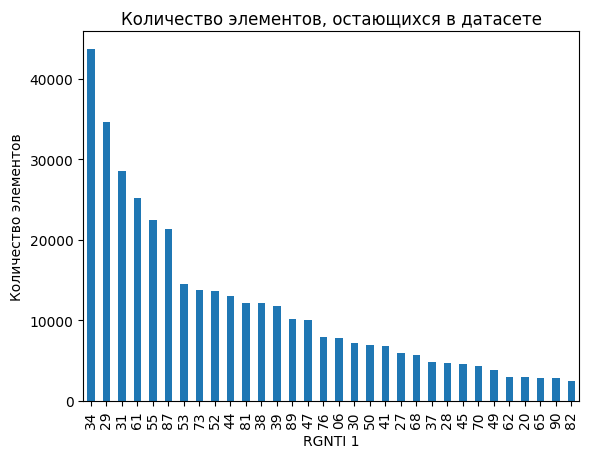

In [7]:
if not os.path.exists(path_info_before_save):
    os.makedirs(path_info_before_save)
df, df_test, n_classes, n_classes2 = get_grnti1_BERT_dataframes("../datasets/base/ru/raw", 
                                            number_of_delteted_values=number_of_delteted_values, 
                                minimal_number_of_elements_RGNTI2=minimal_number_of_elements_RGNTI2,
                                minimal_number_of_words=minimal_number_of_words,
                                dir_name=path_info_before_save, grnti_folder="grnti_dicts_level1_v2/",
                                change_codes=False)

In [8]:
df.shape

(285159, 13)

In [9]:
n_classes

32

In [10]:
# import pandas as pd

In [11]:
# target_count = pd.Series((np.concatenate(df['target'].values))).value_counts()

In [12]:
# target_count.values/ sum(target_count.values).sum()

In [13]:
df['text'] = df['text'].progress_apply(clear_text)

  0%|          | 0/285159 [00:00<?, ?it/s]

In [14]:
df_test['text'] = df_test['text'].progress_apply(clear_text)

  0%|          | 0/166183 [00:00<?, ?it/s]

In [15]:
train_dataset, validation_dataset, test_dataset,\
tokenizer, collate_fn, class_weights = prepair_datasets(df, df_test,
                                                        n_classes, 
                                                        level = '',
                                                        max_number_tokens=max_number_tokens, 
                                                        pre_trained_model_name=pre_trained_model_name)

Веса для кажого класса:  tensor([1.3164, 1.2443, 1.5663, 0.6472, 3.6027, 0.2040, 3.0185, 1.4897, 3.1646,
        0.8802, 1.2860, 2.2852, 0.4165, 0.3968, 1.1249, 0.3536, 1.9390, 0.7354,
        1.8193, 0.3115, 0.8897, 0.2691, 0.6810, 0.6133, 0.6533, 0.7356, 2.0284,
        0.7524, 1.9058, 3.0932, 1.1319, 3.0083], dtype=torch.float64)
Подготовка тренировочных данных:


Map:   0%|          | 0/228152 [00:00<?, ? examples/s]

Подготовка валидационных данных:


Map:   0%|          | 0/57007 [00:00<?, ? examples/s]

Подготовка тестовых данных:


Map:   0%|          | 0/166183 [00:00<?, ? examples/s]

In [16]:
n_classes

32

In [17]:
# from transformers import AutoModelForSequenceClassification

In [18]:
# model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased',
#                                                             problem_type="multi_label_classification",
#                                                             num_labels=n_classes)

In [19]:
# len(list(model.parameters())), len(model.state_dict().items())

In [20]:
model = prepair_model(n_classes=n_classes, 
                      pre_trained_model_name=pre_trained_model_name,
                        r=r, lora_alpha=lora_alpha, 
                        lora_dropout=lora_dropout)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [21]:
model.to("cuda");

In [22]:
save_parameters(dir_name= dir_name, 
                number_of_delteted_values = number_of_delteted_values, 
                minimal_number_of_elements_RGNTI2= minimal_number_of_elements_RGNTI2,
                minimal_number_of_words = minimal_number_of_words, 
                max_number_tokens= max_number_tokens, 
                pre_trained_model_name= pre_trained_model_name,
                r=r, 
                lora_alpha= lora_alpha, lora_dropout = lora_dropout,
                epoch= epoch, 
                batch_size= batch_size,
                weight_decay= weight_decay,
                warmup_steps= warmup_steps,
                fp16=fp16, 
                optim= optim)

In [23]:
compute_metrics = prepair_compute_metrics(n_classes=n_classes)


In [24]:
training_args = TrainingArguments(
    output_dir=dir_name,          
    num_train_epochs=epoch,
    warmup_steps=warmup_steps,
    logging_dir=dir_name,
    weight_decay=weight_decay,
    eval_strategy='epoch',
    save_strategy= "epoch",
    logging_strategy="steps",
    logging_steps = 100,
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to='tensorboard',
    overwrite_output_dir = False,
    save_safetensors = False,
    fp16=fp16,
    optim = optim,
    per_device_train_batch_size= batch_size,
    per_device_eval_batch_size= batch_size,
    group_by_length=True,
    dataloader_num_workers = 4,
    metric_for_best_model="eval_f1_weighted_0.5",
    )

In [25]:
train_dataset = train_dataset.remove_columns("text")
validation_dataset = validation_dataset.remove_columns(["text", "__index_level_0__"])

In [26]:
# train_dataset = train_dataset.remove_columns("text")
# validation_dataset = train_dataset.remove_columns(["text"])

In [27]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    data_collator = collate_fn,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

In [28]:
train_dataset, validation_dataset

(Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 228152
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 57007
 }))

In [29]:
class_weights

tensor([1.3164, 1.2443, 1.5663, 0.6472, 3.6027, 0.2040, 3.0185, 1.4897, 3.1646,
        0.8802, 1.2860, 2.2852, 0.4165, 0.3968, 1.1249, 0.3536, 1.9390, 0.7354,
        1.8193, 0.3115, 0.8897, 0.2691, 0.6810, 0.6133, 0.6533, 0.7356, 2.0284,
        0.7524, 1.9058, 3.0932, 1.1319, 3.0083], dtype=torch.float64)

In [30]:
trainer.get_num_trainable_parameters()

615200

In [ ]:
trainer.get_num_trainable_parameters() #615200 без lora

615200

In [32]:
trainer.train()

  0%|          | 0/456304 [00:00<?, ?it/s]

c:\Users\victo\git_Work_VINITI_2024\my_venv_cuda\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.4779, 'grad_norm': 0.3664964735507965, 'learning_rate': 4.999013793738248e-05, 'epoch': 0.0}
{'loss': 0.1545, 'grad_norm': 0.24914506077766418, 'learning_rate': 4.997918009002968e-05, 'epoch': 0.01}
{'loss': 0.1443, 'grad_norm': 0.27244967222213745, 'learning_rate': 4.996822224267687e-05, 'epoch': 0.01}
{'loss': 0.1401, 'grad_norm': 0.36175674200057983, 'learning_rate': 4.995726439532407e-05, 'epoch': 0.01}
{'loss': 0.1394, 'grad_norm': 0.1879006177186966, 'learning_rate': 4.9946306547971265e-05, 'epoch': 0.02}
{'loss': 0.1321, 'grad_norm': 0.40387728810310364, 'learning_rate': 4.9935348700618465e-05, 'epoch': 0.02}
{'loss': 0.129, 'grad_norm': 0.17966414988040924, 'learning_rate': 4.9924390853265665e-05, 'epoch': 0.02}
{'loss': 0.132, 'grad_norm': 0.2848368287086487, 'learning_rate': 4.991343300591286e-05, 'epoch': 0.03}
{'loss': 0.1267, 'grad_norm': 0.3152472674846649, 'learning_rate': 4.990247515856005e-05, 'epoch': 0.03}
{'loss': 0.1366, 'grad_norm': 0.2622925639152527, 

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.06258266419172287, 'eval_accuracy_micro_0.5': 0.9736682772636414, 'eval_accuracy_macro_0.5': 0.9736683368682861, 'eval_accuracy_weighted_0.5': 0.9618131518363953, 'eval_f1_micro_0.5': 0.6026389002799988, 'eval_f1_macro_0.5': 0.5135421752929688, 'eval_f1_weighted_0.5': 0.5716304779052734, 'eval_f1_micro_0.6': 0.5517911911010742, 'eval_f1_macro_0.6': 0.44868385791778564, 'eval_f1_weighted_0.6': 0.509899377822876, 'eval_f1_micro_0.7': 0.48625925183296204, 'eval_f1_macro_0.7': 0.3746722340583801, 'eval_f1_weighted_0.7': 0.43842893838882446, 'eval_f1_micro_0.8': 0.3975013792514801, 'eval_f1_macro_0.8': 0.17065250873565674, 'eval_f1_weighted_0.8': 0.22833728790283203, 'eval_f1_micro_0.9': 0.25708213448524475, 'eval_aucroc_micro': 0.8442557454109192, 'eval_aucroc_macro': 0.8145055770874023, 'eval_aucroc_weighted': 0.8401778340339661, 'eval_runtime': 2040.3902, 'eval_samples_per_second': 27.939, 'eval_steps_per_second': 3.492, 'epoch': 1.0}
{'loss': 0.0626, 'grad_norm': 0.37982

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.05816683918237686, 'eval_accuracy_micro_0.5': 0.9754306674003601, 'eval_accuracy_macro_0.5': 0.9754306674003601, 'eval_accuracy_weighted_0.5': 0.9644905924797058, 'eval_f1_micro_0.5': 0.6444888710975647, 'eval_f1_macro_0.5': 0.5701881051063538, 'eval_f1_weighted_0.5': 0.6223758459091187, 'eval_f1_micro_0.6': 0.6038420796394348, 'eval_f1_macro_0.6': 0.515790581703186, 'eval_f1_weighted_0.6': 0.571593165397644, 'eval_f1_micro_0.7': 0.5449698567390442, 'eval_f1_macro_0.7': 0.44283175468444824, 'eval_f1_weighted_0.7': 0.5035303831100464, 'eval_f1_micro_0.8': 0.4611920416355133, 'eval_f1_macro_0.8': 0.22910304367542267, 'eval_f1_weighted_0.8': 0.2860172688961029, 'eval_f1_micro_0.9': 0.3229879140853882, 'eval_aucroc_micro': 0.8658251166343689, 'eval_aucroc_macro': 0.8387537598609924, 'eval_aucroc_weighted': 0.8616979718208313, 'eval_runtime': 1962.2205, 'eval_samples_per_second': 29.052, 'eval_steps_per_second': 3.632, 'epoch': 2.0}
{'loss': 0.0581, 'grad_norm': 0.1422099173

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.05637985095381737, 'eval_accuracy_micro_0.5': 0.9763187170028687, 'eval_accuracy_macro_0.5': 0.9763187170028687, 'eval_accuracy_weighted_0.5': 0.9657496809959412, 'eval_f1_micro_0.5': 0.6638184785842896, 'eval_f1_macro_0.5': 0.5970748662948608, 'eval_f1_weighted_0.5': 0.6457220911979675, 'eval_f1_micro_0.6': 0.6251160502433777, 'eval_f1_macro_0.6': 0.5438995361328125, 'eval_f1_weighted_0.6': 0.5968449711799622, 'eval_f1_micro_0.7': 0.5702435374259949, 'eval_f1_macro_0.7': 0.4757663309574127, 'eval_f1_weighted_0.7': 0.5316706895828247, 'eval_f1_micro_0.8': 0.4893404245376587, 'eval_f1_macro_0.8': 0.26064279675483704, 'eval_f1_weighted_0.8': 0.309933602809906, 'eval_f1_micro_0.9': 0.35078516602516174, 'eval_aucroc_micro': 0.8743852972984314, 'eval_aucroc_macro': 0.8498550057411194, 'eval_aucroc_weighted': 0.8704034686088562, 'eval_runtime': 1961.7067, 'eval_samples_per_second': 29.06, 'eval_steps_per_second': 3.633, 'epoch': 3.0}
{'loss': 0.0634, 'grad_norm': 0.2530371844

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.0548434741795063, 'eval_accuracy_micro_0.5': 0.9766695499420166, 'eval_accuracy_macro_0.5': 0.9766694903373718, 'eval_accuracy_weighted_0.5': 0.9662999510765076, 'eval_f1_micro_0.5': 0.666217029094696, 'eval_f1_macro_0.5': 0.5995780229568481, 'eval_f1_weighted_0.5': 0.6458981037139893, 'eval_f1_micro_0.6': 0.6288735866546631, 'eval_f1_macro_0.6': 0.5508895516395569, 'eval_f1_weighted_0.6': 0.5993890762329102, 'eval_f1_micro_0.7': 0.5740097761154175, 'eval_f1_macro_0.7': 0.4864501953125, 'eval_f1_weighted_0.7': 0.5363894701004028, 'eval_f1_micro_0.8': 0.49490848183631897, 'eval_f1_macro_0.8': 0.2740723192691803, 'eval_f1_weighted_0.8': 0.3218640387058258, 'eval_f1_micro_0.9': 0.35971397161483765, 'eval_aucroc_micro': 0.8713582158088684, 'eval_aucroc_macro': 0.8482685089111328, 'eval_aucroc_weighted': 0.8680399060249329, 'eval_runtime': 2002.4628, 'eval_samples_per_second': 28.468, 'eval_steps_per_second': 3.559, 'epoch': 4.0}
{'loss': 0.0513, 'grad_norm': 0.1009455174207

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.054108697921037674, 'eval_accuracy_micro_0.5': 0.9770675301551819, 'eval_accuracy_macro_0.5': 0.9770675897598267, 'eval_accuracy_weighted_0.5': 0.9668362736701965, 'eval_f1_micro_0.5': 0.6734728813171387, 'eval_f1_macro_0.5': 0.6085836291313171, 'eval_f1_weighted_0.5': 0.6566839814186096, 'eval_f1_micro_0.6': 0.6351084113121033, 'eval_f1_macro_0.6': 0.5609654784202576, 'eval_f1_weighted_0.6': 0.6102758049964905, 'eval_f1_micro_0.7': 0.5773624777793884, 'eval_f1_macro_0.7': 0.49537405371665955, 'eval_f1_weighted_0.7': 0.5447242259979248, 'eval_f1_micro_0.8': 0.4925903081893921, 'eval_f1_macro_0.8': 0.27916765213012695, 'eval_f1_weighted_0.8': 0.31416136026382446, 'eval_f1_micro_0.9': 0.3495982587337494, 'eval_aucroc_micro': 0.8762131929397583, 'eval_aucroc_macro': 0.8527284860610962, 'eval_aucroc_weighted': 0.8726765513420105, 'eval_runtime': 2039.1818, 'eval_samples_per_second': 27.956, 'eval_steps_per_second': 3.495, 'epoch': 5.0}
{'loss': 0.0557, 'grad_norm': 0.082422

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.05341868847608566, 'eval_accuracy_micro_0.5': 0.9773410558700562, 'eval_accuracy_macro_0.5': 0.9773411154747009, 'eval_accuracy_weighted_0.5': 0.9672285318374634, 'eval_f1_micro_0.5': 0.6790785789489746, 'eval_f1_macro_0.5': 0.6225569844245911, 'eval_f1_weighted_0.5': 0.6634640693664551, 'eval_f1_micro_0.6': 0.6428613066673279, 'eval_f1_macro_0.6': 0.5765226483345032, 'eval_f1_weighted_0.6': 0.6186526417732239, 'eval_f1_micro_0.7': 0.5879366397857666, 'eval_f1_macro_0.7': 0.5104986429214478, 'eval_f1_weighted_0.7': 0.5547484159469604, 'eval_f1_micro_0.8': 0.5104460716247559, 'eval_f1_macro_0.8': 0.29825520515441895, 'eval_f1_weighted_0.8': 0.3366132080554962, 'eval_f1_micro_0.9': 0.3741466999053955, 'eval_aucroc_micro': 0.8785142302513123, 'eval_aucroc_macro': 0.8591352701187134, 'eval_aucroc_weighted': 0.8752666115760803, 'eval_runtime': 2057.8042, 'eval_samples_per_second': 27.703, 'eval_steps_per_second': 3.463, 'epoch': 6.0}
{'loss': 0.0553, 'grad_norm': 0.171499997

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.052715349942445755, 'eval_accuracy_micro_0.5': 0.9776918888092041, 'eval_accuracy_macro_0.5': 0.9776919484138489, 'eval_accuracy_weighted_0.5': 0.9677637815475464, 'eval_f1_micro_0.5': 0.6842778921127319, 'eval_f1_macro_0.5': 0.6247463226318359, 'eval_f1_weighted_0.5': 0.6685571074485779, 'eval_f1_micro_0.6': 0.6468893885612488, 'eval_f1_macro_0.6': 0.5775485038757324, 'eval_f1_weighted_0.6': 0.6227774620056152, 'eval_f1_micro_0.7': 0.5922484993934631, 'eval_f1_macro_0.7': 0.5089188814163208, 'eval_f1_weighted_0.7': 0.5584977865219116, 'eval_f1_micro_0.8': 0.5144245624542236, 'eval_f1_macro_0.8': 0.2953706681728363, 'eval_f1_weighted_0.8': 0.3402799069881439, 'eval_f1_micro_0.9': 0.3811555802822113, 'eval_aucroc_micro': 0.8791090846061707, 'eval_aucroc_macro': 0.857340931892395, 'eval_aucroc_weighted': 0.875852644443512, 'eval_runtime': 1937.3883, 'eval_samples_per_second': 29.425, 'eval_steps_per_second': 3.678, 'epoch': 7.0}
{'loss': 0.0564, 'grad_norm': 0.30742007493

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.05211970582604408, 'eval_accuracy_micro_0.5': 0.9778755307197571, 'eval_accuracy_macro_0.5': 0.9778755307197571, 'eval_accuracy_weighted_0.5': 0.9681129455566406, 'eval_f1_micro_0.5': 0.6889978051185608, 'eval_f1_macro_0.5': 0.6269444823265076, 'eval_f1_weighted_0.5': 0.6724046468734741, 'eval_f1_micro_0.6': 0.6535751223564148, 'eval_f1_macro_0.6': 0.5794132351875305, 'eval_f1_weighted_0.6': 0.6281954050064087, 'eval_f1_micro_0.7': 0.602444052696228, 'eval_f1_macro_0.7': 0.5174075365066528, 'eval_f1_weighted_0.7': 0.568256139755249, 'eval_f1_micro_0.8': 0.5270305275917053, 'eval_f1_macro_0.8': 0.30579674243927, 'eval_f1_weighted_0.8': 0.35505032539367676, 'eval_f1_micro_0.9': 0.39408379793167114, 'eval_aucroc_micro': 0.8821734189987183, 'eval_aucroc_macro': 0.8593533635139465, 'eval_aucroc_weighted': 0.8788361549377441, 'eval_runtime': 1898.3768, 'eval_samples_per_second': 30.029, 'eval_steps_per_second': 3.754, 'epoch': 8.0}
{'loss': 0.0562, 'grad_norm': 0.236933812499

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.051702942699193954, 'eval_accuracy_micro_0.5': 0.9780070781707764, 'eval_accuracy_macro_0.5': 0.9780070781707764, 'eval_accuracy_weighted_0.5': 0.9682323932647705, 'eval_f1_micro_0.5': 0.6895073056221008, 'eval_f1_macro_0.5': 0.6298611164093018, 'eval_f1_weighted_0.5': 0.67431640625, 'eval_f1_micro_0.6': 0.6542431116104126, 'eval_f1_macro_0.6': 0.583878219127655, 'eval_f1_weighted_0.6': 0.6311377286911011, 'eval_f1_micro_0.7': 0.6007118821144104, 'eval_f1_macro_0.7': 0.5197815895080566, 'eval_f1_weighted_0.7': 0.5690696239471436, 'eval_f1_micro_0.8': 0.5225966572761536, 'eval_f1_macro_0.8': 0.30627161264419556, 'eval_f1_weighted_0.8': 0.3495624363422394, 'eval_f1_micro_0.9': 0.38825279474258423, 'eval_aucroc_micro': 0.8819599747657776, 'eval_aucroc_macro': 0.8599821925163269, 'eval_aucroc_weighted': 0.8786696195602417, 'eval_runtime': 1920.6471, 'eval_samples_per_second': 29.681, 'eval_steps_per_second': 3.71, 'epoch': 9.0}
{'loss': 0.0498, 'grad_norm': 0.17284436523914

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.051229607313871384, 'eval_accuracy_micro_0.5': 0.9780734181404114, 'eval_accuracy_macro_0.5': 0.9780734181404114, 'eval_accuracy_weighted_0.5': 0.968302845954895, 'eval_f1_micro_0.5': 0.6904126405715942, 'eval_f1_macro_0.5': 0.6335127353668213, 'eval_f1_weighted_0.5': 0.6761664748191833, 'eval_f1_micro_0.6': 0.6546387672424316, 'eval_f1_macro_0.6': 0.5866681933403015, 'eval_f1_weighted_0.6': 0.6327769756317139, 'eval_f1_micro_0.7': 0.6012930274009705, 'eval_f1_macro_0.7': 0.521671712398529, 'eval_f1_weighted_0.7': 0.5707725286483765, 'eval_f1_micro_0.8': 0.523930549621582, 'eval_f1_macro_0.8': 0.30752331018447876, 'eval_f1_weighted_0.8': 0.3505420684814453, 'eval_f1_micro_0.9': 0.38824188709259033, 'eval_aucroc_micro': 0.8816949129104614, 'eval_aucroc_macro': 0.8600898385047913, 'eval_aucroc_weighted': 0.8785336017608643, 'eval_runtime': 2068.7086, 'eval_samples_per_second': 27.557, 'eval_steps_per_second': 3.445, 'epoch': 10.0}
{'loss': 0.0518, 'grad_norm': 0.187458604

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.05094081535935402, 'eval_accuracy_micro_0.5': 0.9781490564346313, 'eval_accuracy_macro_0.5': 0.9781490564346313, 'eval_accuracy_weighted_0.5': 0.9684460163116455, 'eval_f1_micro_0.5': 0.6914663910865784, 'eval_f1_macro_0.5': 0.6295072436332703, 'eval_f1_weighted_0.5': 0.6746317148208618, 'eval_f1_micro_0.6': 0.6571081876754761, 'eval_f1_macro_0.6': 0.5829939842224121, 'eval_f1_weighted_0.6': 0.6316925883293152, 'eval_f1_micro_0.7': 0.6054972410202026, 'eval_f1_macro_0.7': 0.5173655152320862, 'eval_f1_weighted_0.7': 0.5704308748245239, 'eval_f1_micro_0.8': 0.531339168548584, 'eval_f1_macro_0.8': 0.30703404545783997, 'eval_f1_weighted_0.8': 0.35971948504447937, 'eval_f1_micro_0.9': 0.4055984318256378, 'eval_aucroc_micro': 0.8817095160484314, 'eval_aucroc_macro': 0.8581146001815796, 'eval_aucroc_weighted': 0.8784018158912659, 'eval_runtime': 2072.6678, 'eval_samples_per_second': 27.504, 'eval_steps_per_second': 3.438, 'epoch': 11.0}
{'loss': 0.0525, 'grad_norm': 0.27956748

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.05086900666356087, 'eval_accuracy_micro_0.5': 0.9782647490501404, 'eval_accuracy_macro_0.5': 0.9782647490501404, 'eval_accuracy_weighted_0.5': 0.9686293005943298, 'eval_f1_micro_0.5': 0.6951266527175903, 'eval_f1_macro_0.5': 0.6391926407814026, 'eval_f1_weighted_0.5': 0.6803233623504639, 'eval_f1_micro_0.6': 0.6609800457954407, 'eval_f1_macro_0.6': 0.5949001908302307, 'eval_f1_weighted_0.6': 0.6382536888122559, 'eval_f1_micro_0.7': 0.6100691556930542, 'eval_f1_macro_0.7': 0.5307891368865967, 'eval_f1_weighted_0.7': 0.5777235627174377, 'eval_f1_micro_0.8': 0.5350989103317261, 'eval_f1_macro_0.8': 0.32023313641548157, 'eval_f1_weighted_0.8': 0.36554503440856934, 'eval_f1_micro_0.9': 0.4071471095085144, 'eval_aucroc_micro': 0.8844704627990723, 'eval_aucroc_macro': 0.8643602132797241, 'eval_aucroc_weighted': 0.881335437297821, 'eval_runtime': 1914.5789, 'eval_samples_per_second': 29.775, 'eval_steps_per_second': 3.722, 'epoch': 12.0}
{'loss': 0.056, 'grad_norm': 0.402858138

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.05086708813905716, 'eval_accuracy_micro_0.5': 0.9783414602279663, 'eval_accuracy_macro_0.5': 0.9783414602279663, 'eval_accuracy_weighted_0.5': 0.9686963558197021, 'eval_f1_micro_0.5': 0.6979727149009705, 'eval_f1_macro_0.5': 0.6433895230293274, 'eval_f1_weighted_0.5': 0.6835759282112122, 'eval_f1_micro_0.6': 0.6655101776123047, 'eval_f1_macro_0.6': 0.602014422416687, 'eval_f1_weighted_0.6': 0.6431887745857239, 'eval_f1_micro_0.7': 0.6148824095726013, 'eval_f1_macro_0.7': 0.5382464528083801, 'eval_f1_weighted_0.7': 0.5827292799949646, 'eval_f1_micro_0.8': 0.5402607917785645, 'eval_f1_macro_0.8': 0.3262481689453125, 'eval_f1_weighted_0.8': 0.36947253346443176, 'eval_f1_micro_0.9': 0.4132797420024872, 'eval_aucroc_micro': 0.887194812297821, 'eval_aucroc_macro': 0.8682030439376831, 'eval_aucroc_weighted': 0.8840101957321167, 'eval_runtime': 1903.078, 'eval_samples_per_second': 29.955, 'eval_steps_per_second': 3.744, 'epoch': 13.0}
{'loss': 0.0562, 'grad_norm': 0.16582804918

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.050525590777397156, 'eval_accuracy_micro_0.5': 0.9783633947372437, 'eval_accuracy_macro_0.5': 0.9783633947372437, 'eval_accuracy_weighted_0.5': 0.9687404632568359, 'eval_f1_micro_0.5': 0.6966739296913147, 'eval_f1_macro_0.5': 0.6406983733177185, 'eval_f1_weighted_0.5': 0.6819546222686768, 'eval_f1_micro_0.6': 0.6625007390975952, 'eval_f1_macro_0.6': 0.5960221290588379, 'eval_f1_weighted_0.6': 0.640026867389679, 'eval_f1_micro_0.7': 0.6120135188102722, 'eval_f1_macro_0.7': 0.5333943367004395, 'eval_f1_weighted_0.7': 0.5804529786109924, 'eval_f1_micro_0.8': 0.535961389541626, 'eval_f1_macro_0.8': 0.3223661780357361, 'eval_f1_weighted_0.8': 0.36449456214904785, 'eval_f1_micro_0.9': 0.4047316908836365, 'eval_aucroc_micro': 0.8850463032722473, 'eval_aucroc_macro': 0.8643282055854797, 'eval_aucroc_weighted': 0.8818269371986389, 'eval_runtime': 1845.7282, 'eval_samples_per_second': 30.886, 'eval_steps_per_second': 3.861, 'epoch': 14.0}
{'loss': 0.0529, 'grad_norm': 0.224517002

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.05039722099900246, 'eval_accuracy_micro_0.5': 0.9783918857574463, 'eval_accuracy_macro_0.5': 0.9783919453620911, 'eval_accuracy_weighted_0.5': 0.9688023924827576, 'eval_f1_micro_0.5': 0.6962659358978271, 'eval_f1_macro_0.5': 0.6401736736297607, 'eval_f1_weighted_0.5': 0.6812376976013184, 'eval_f1_micro_0.6': 0.662589967250824, 'eval_f1_macro_0.6': 0.5965428352355957, 'eval_f1_weighted_0.6': 0.6400261521339417, 'eval_f1_micro_0.7': 0.610707700252533, 'eval_f1_macro_0.7': 0.5328935980796814, 'eval_f1_weighted_0.7': 0.5793792605400085, 'eval_f1_micro_0.8': 0.5350857973098755, 'eval_f1_macro_0.8': 0.3223875164985657, 'eval_f1_weighted_0.8': 0.36426612734794617, 'eval_f1_micro_0.9': 0.4034256041049957, 'eval_aucroc_micro': 0.8843632936477661, 'eval_aucroc_macro': 0.8637553453445435, 'eval_aucroc_weighted': 0.881332516670227, 'eval_runtime': 1823.3117, 'eval_samples_per_second': 31.266, 'eval_steps_per_second': 3.908, 'epoch': 15.0}
{'loss': 0.0544, 'grad_norm': 0.33883073925

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.05040523409843445, 'eval_accuracy_micro_0.5': 0.9784401655197144, 'eval_accuracy_macro_0.5': 0.9784401655197144, 'eval_accuracy_weighted_0.5': 0.9688714742660522, 'eval_f1_micro_0.5': 0.6974987983703613, 'eval_f1_macro_0.5': 0.64133220911026, 'eval_f1_weighted_0.5': 0.6826077699661255, 'eval_f1_micro_0.6': 0.6639683246612549, 'eval_f1_macro_0.6': 0.5974292755126953, 'eval_f1_weighted_0.6': 0.6414457559585571, 'eval_f1_micro_0.7': 0.6125698685646057, 'eval_f1_macro_0.7': 0.5339789390563965, 'eval_f1_weighted_0.7': 0.5805332064628601, 'eval_f1_micro_0.8': 0.5376940965652466, 'eval_f1_macro_0.8': 0.32331547141075134, 'eval_f1_weighted_0.8': 0.3667091429233551, 'eval_f1_micro_0.9': 0.4075469970703125, 'eval_aucroc_micro': 0.8851088881492615, 'eval_aucroc_macro': 0.8646185398101807, 'eval_aucroc_weighted': 0.8819605708122253, 'eval_runtime': 10291.7275, 'eval_samples_per_second': 5.539, 'eval_steps_per_second': 0.692, 'epoch': 16.0}
{'train_runtime': 121868.9591, 'train_samp

TrainOutput(global_step=456304, training_loss=0.05760472739591681, metrics={'train_runtime': 121868.9591, 'train_samples_per_second': 29.954, 'train_steps_per_second': 3.744, 'total_flos': 3.858190580276352e+17, 'train_loss': 0.05760472739591681, 'epoch': 16.0})

In [33]:
trainer.model.save_pretrained(dir_name + "bert_peft_level1_no_lora")

In [34]:
# trainer.save_model("bert_peft_level1_v2")

### Тest level 1

In [35]:
test_dataset = test_dataset.remove_columns(["text", "__index_level_0__"])

In [36]:
predict_res = trainer.predict(test_dataset=test_dataset).predictions


  0%|          | 0/20773 [00:00<?, ?it/s]

In [37]:
with open(dir_name + "trainer_predictions_level1_no_lora.npy", 'wb') as f:
    np.save(f, predict_res)

In [38]:



    
with open(dir_name + "trainer_predictions_level1_no_lora.npy", 'rb') as f:

    prediction1_experiment = np.load(f)

In [39]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [40]:
label_test = np.vstack(df_test["target_coded"])

In [41]:
test_predictons(sigmoid_array(prediction1_experiment), label_test, path_info_before_save, 32,# было 36, поэтому фэйл 
                level=1,
                grnti_path="grnti_dicts_level1/")

100%|██████████| 18/18 [00:45<00:00,  2.52s/it]


Cтатистика количества пркдсказываемых классов при заданном threshold:
Среднее число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1.3958)
Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1)
Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(5)
Доля статей c пустым ответом классификатора (Empty): 0.07520023107056684
recall_micro_list threshold: [tensor(0.8982), tensor(0.8591), tensor(0.8211), tensor(0.7866), tensor(0.7524), tensor(0.7184), tensor(0.6853), tensor(0.6519), tensor(0.6184), tensor(0.5841), tensor(0.5486), tensor(0.5119), tensor(0.4725), tensor(0.4304), tensor(0.3843), tensor(0.3309), tensor(0.2657), tensor(0.1746)]
recall_macro_list threshold: [tensor(0.8733), tensor(0.8281), tensor(0.7857), tensor(0.7481), tensor(0.7117), tensor(0.6764), tensor(0.6415), tensor(0.6060), tensor(0.5707), tensor(0.5352), tensor(0.4990), tensor(0.4619), ten

100%|██████████| 18/18 [00:00<00:00, 51.74it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 3/3 [00:10<00:00,  3.63s/it]


Количество отказов от классификации (Reject) tensor(0)
Доля отказов от классификации (Reject) tensor(0.)
f1_top_k_macro [0.61 0.59 0.5 ]
f1_top_k_maicro [0.68 0.62 0.52]
f1_top_k_weighted [0.66 0.64 0.55]
precision_top_k_macro [0.73 0.48 0.36]
precision_top_k_maicro [0.77 0.51 0.37]
precision_top_k_weighted [0.76 0.53 0.41]
recall_top_k_macro: tensor([0.5544, 0.7729, 0.8612])
recall_top_k_micro: tensor([0.6066, 0.8062, 0.8847])
recall_top_k_weighted: tensor([0.6066, 0.8062, 0.8847])


<Figure size 640x480 with 0 Axes>

In [42]:
# model = prepair_model_test(n_classes=36, lora_model_path = "bert_peft_level1")

### Train level 2 no labels correct

In [3]:
max_number_tokens = 512
pre_trained_model_name ='DeepPavlov/rubert-base-cased'
r = 16
lora_alpha = 16
lora_dropout = 0.05

In [4]:
base_name = "results_6_more_epoch_clear_data/"
number_of_delteted_values = 0
minimal_number_of_elements_RGNTI2 = 300
minimal_number_of_words = 10

path_info_before_save = base_name + f"data_info_from_bert_level2_no_label/"

In [5]:
epoch= 8
batch_size=8
weight_decay = 1e-6
warmup_steps = 10
fp16 = True
optim = "adamw_bnb_8bit"
dir_name = base_name + f"model bert lora level 2 no labels/"

Удаление элементов второго уровня, количство которых меньше 300
         id_publ                                              title  \
0   19.06-73.269  Некоторые аспекты изменения степных ландшафтов...   
1   19.01-24А.85  Подходы к повышению точности определения харак...   
2   19.06-66.105  Микроскопическое моделирование фазового поля п...   
3   19.06-14Б.10  МОДЕЛИ И МЕТОДИКИ АВТОМАТИЗАЦИИ ПРОЦЕДУР РАЗРА...   
4  19.10-19Ж.456  Трехкомпонентная реакция Кастагноли-Кушмана 3-...   

                                             ref_txt  \
0  Предлагается результат анализа динамики некото...   
1  В статье представлены подходы к повышению точн...   
2  Процесс выделения сплава Ni[75]Al[15]Ti[10] мо...   
3  Объектом исследования является проектирование ...   
4  Попытки использования 3-арилглутаконовых кисло...   

                                             kw_list   SUBJ     IPV  \
0  Урало-Заволжье\анализ динамики\ландшафты\нефте...  f3\e2   72\73   
1  метровый диапазон\обнаружен

100%|██████████| 47/47 [00:27<00:00,  1.68it/s]


(207, 2)
(246, 2)
Доля оставшихся элементов в тренировочном датасете:  0.9528220888159016


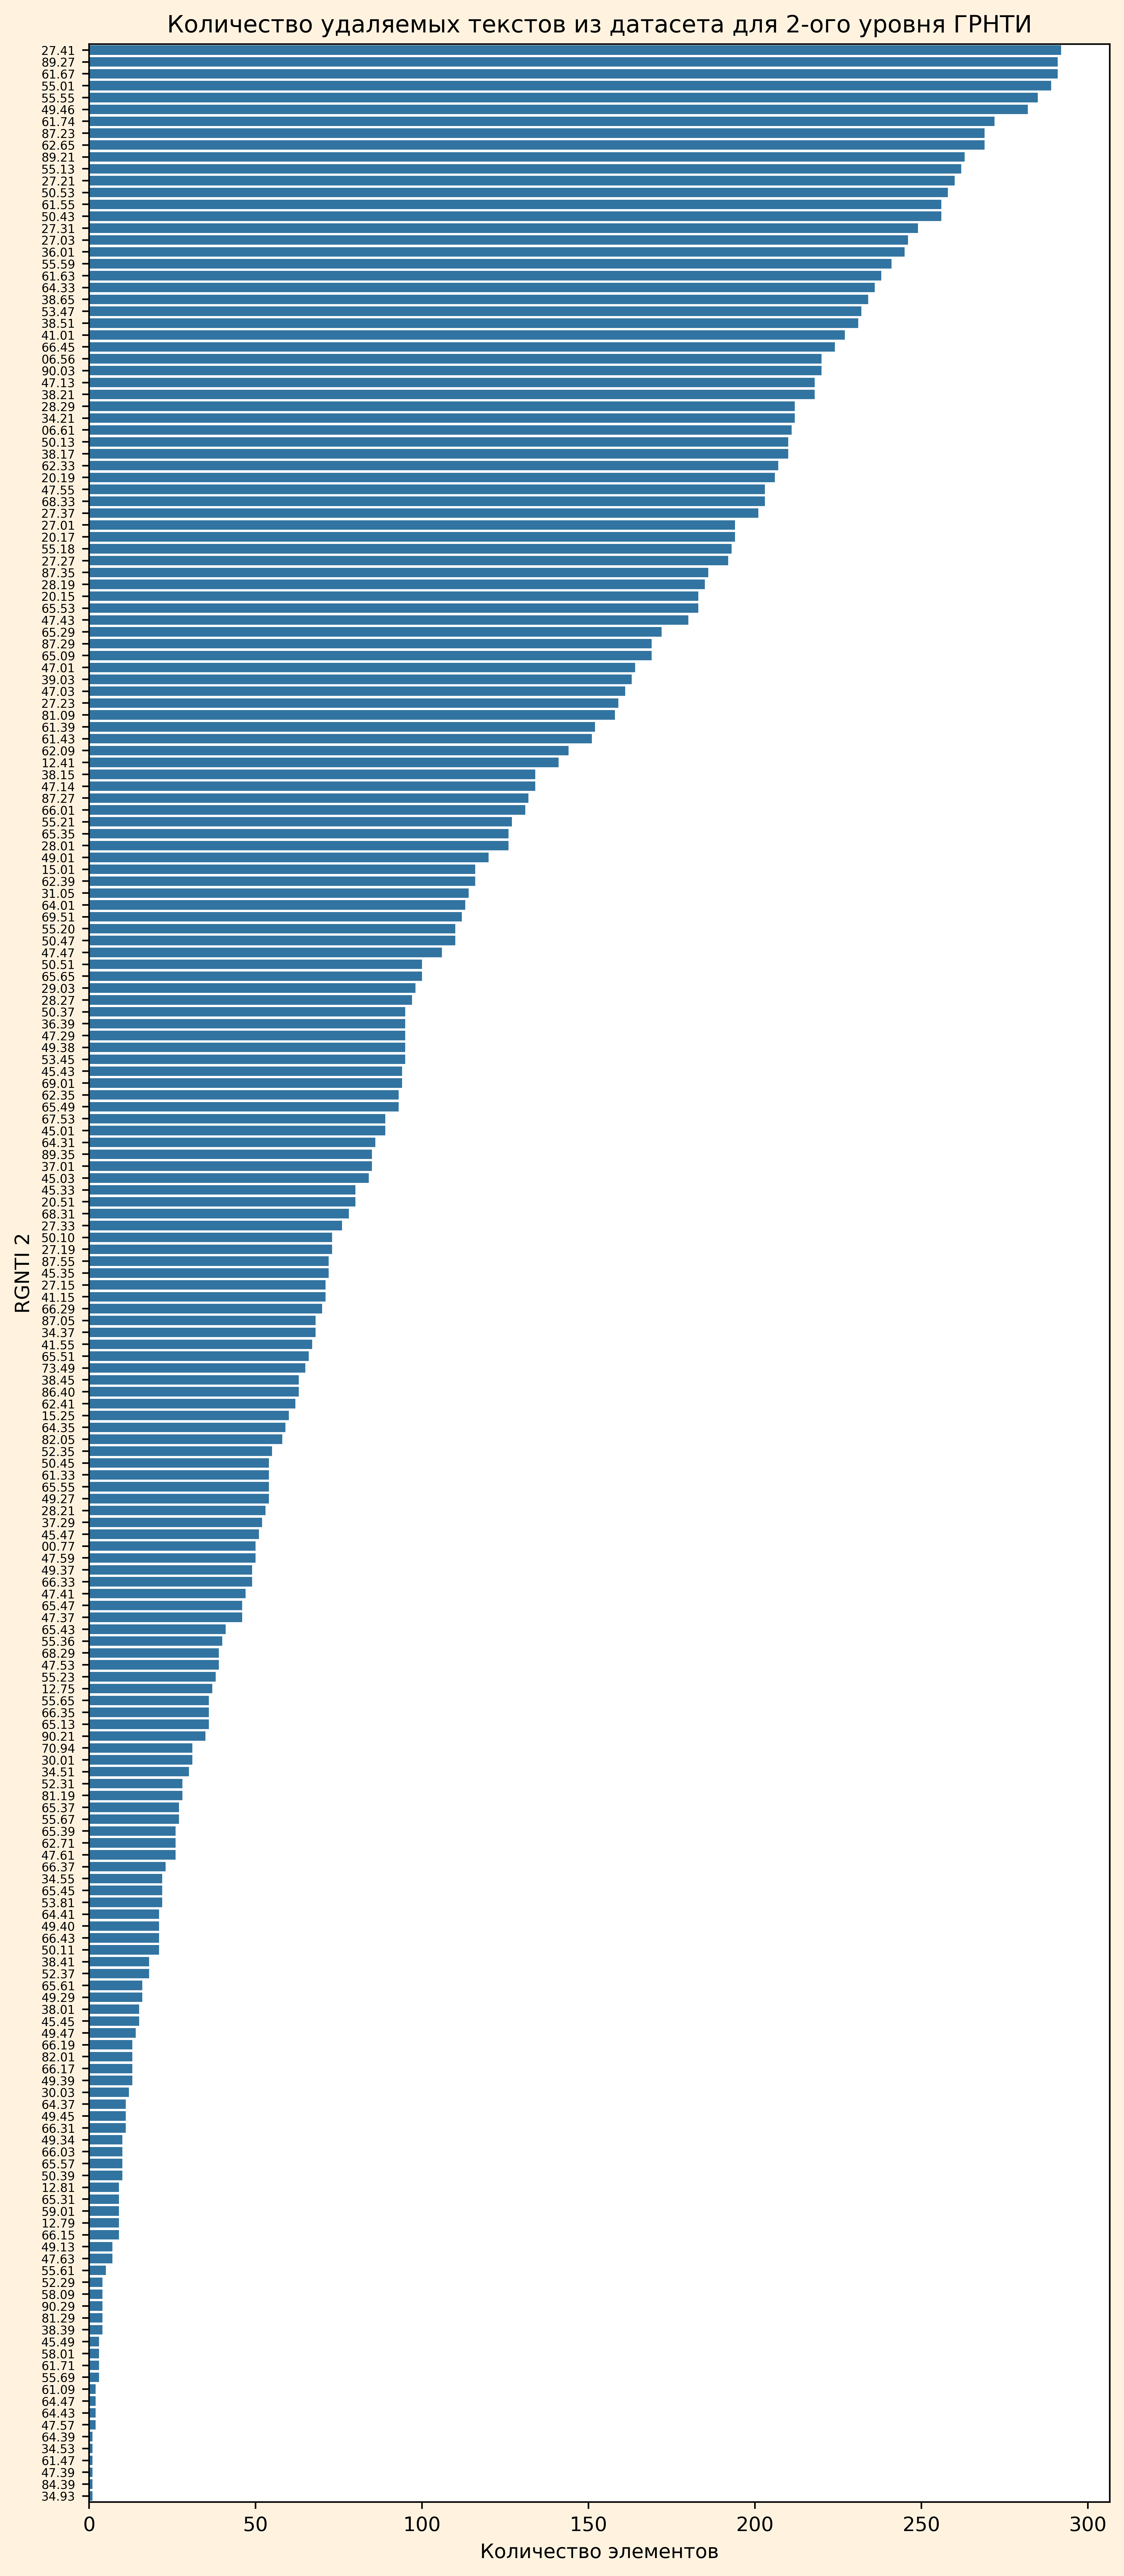

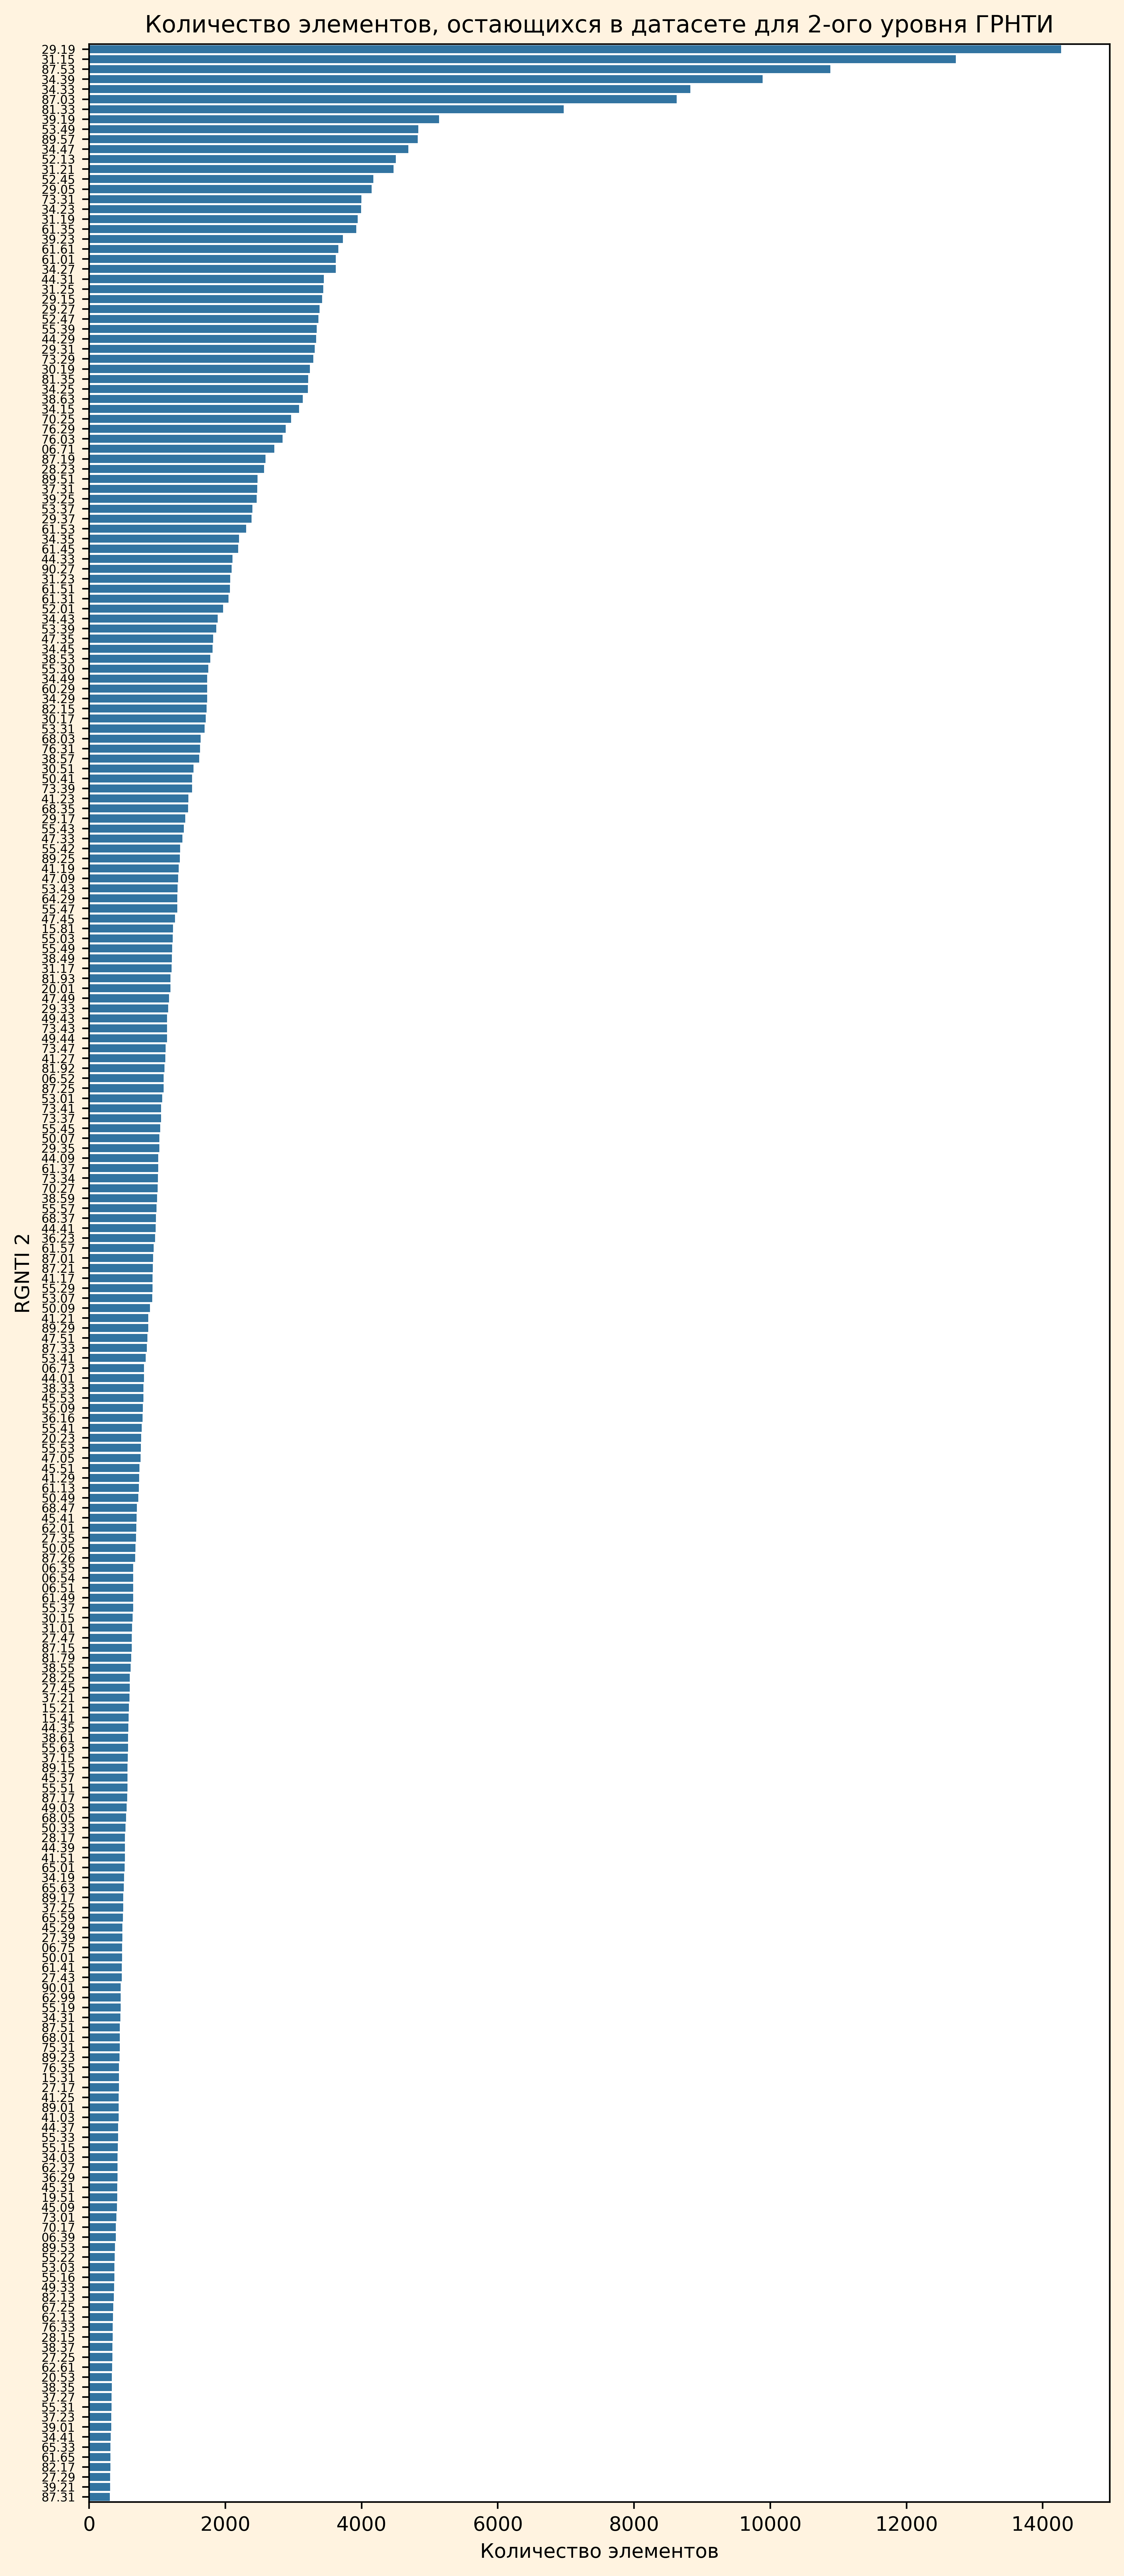

In [6]:
if not os.path.exists(path_info_before_save):
    os.makedirs(path_info_before_save)
df, df_test, n_classes, n_classes2 = get_grnti1_2_BERT_dataframes("../datasets/base/ru/raw", 
                                            number_of_delteted_values=number_of_delteted_values, 
                                minimal_number_of_elements_RGNTI2=minimal_number_of_elements_RGNTI2,
                                minimal_number_of_words=minimal_number_of_words,
                                dir_name=path_info_before_save, grnti_folder = "grnti_dicts_level2/")

In [7]:
df.shape

(279659, 13)

In [8]:
df_test.shape

(166183, 13)

In [16]:
n_classes, n_classes2

(47, 246)

In [11]:
train_dataset, validation_dataset, test_dataset,\
tokenizer, collate_fn, class_weights = prepair_datasets(df, df_test,
                                                        n_classes2, 
                                                        level = '2',
                                                        max_number_tokens=max_number_tokens, 
                                                        pre_trained_model_name=pre_trained_model_name)

Веса для кажого класса:  tensor([0.3324, 0.3050, 1.0957, 1.0359, 1.6289, 0.9368, 0.6091, 1.0129, 0.8051,
        1.0997, 0.9416, 0.4420, 2.2994, 0.6026, 0.3403, 0.5159, 0.6951, 2.6470,
        0.8494, 3.0454, 1.1965, 3.6569, 3.1184, 2.4879, 0.6715, 1.6677, 2.5795,
        0.5499, 1.0763, 2.0101, 2.9092, 1.5381, 0.1151, 1.7578, 2.5722, 0.1291,
        1.8321, 0.9995, 0.1317, 1.5645, 0.3132, 2.1127, 0.9802, 0.8174, 0.3629,
        0.9263, 1.9089, 2.7181, 1.1037, 1.5076, 1.4161, 2.0012, 2.7262, 2.7262,
        0.3832, 2.3348, 2.8367, 1.1719, 1.4710, 1.9752, 1.1934, 1.2076, 0.8656,
        0.6532, 0.3139, 0.1045, 1.6202, 1.8583, 1.9752, 1.4408, 1.7784, 1.1159,
        1.1325, 3.4622, 3.5991, 3.1950, 0.2844, 0.3359, 0.3512, 2.3590, 1.6348,
        2.6703, 0.4615, 1.4976, 1.5355, 0.2724, 0.7789, 2.3590, 0.8486, 0.3538,
        1.1439, 2.5016, 0.8781, 0.7464, 0.3536, 1.3734, 2.4478, 0.2879, 0.5738,
        1.0254, 2.1836, 0.3379, 1.2612, 0.7776, 1.4927, 0.2423, 0.9226, 0.9397,
        0.5495,

Map:   0%|          | 0/223999 [00:00<?, ? examples/s]

Подготовка валидационных данных:


Map:   0%|          | 0/55660 [00:00<?, ? examples/s]

Подготовка тестовых данных:


Map:   0%|          | 0/166183 [00:00<?, ? examples/s]

In [11]:
len(train_dataset['label'][0])

246

In [12]:
len(class_weights)

246

In [13]:
model = prepair_model(n_classes=n_classes2, 
                      pre_trained_model_name=pre_trained_model_name,
                        r=r, lora_alpha=lora_alpha, 
                        lora_dropout=lora_dropout)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [14]:
model.to("cuda");

In [12]:
save_parameters(dir_name= dir_name, 
                number_of_delteted_values = number_of_delteted_values, 
                minimal_number_of_elements_RGNTI2= minimal_number_of_elements_RGNTI2,
                minimal_number_of_words = minimal_number_of_words, 
                max_number_tokens= max_number_tokens, 
                pre_trained_model_name= pre_trained_model_name,
                r=r, 
                lora_alpha= lora_alpha, lora_dropout = lora_dropout,
                epoch= epoch, 
                batch_size= batch_size,
                weight_decay= weight_decay,
                warmup_steps= warmup_steps,
                fp16=fp16, 
                optim= optim)

In [16]:
compute_metrics = prepair_compute_metrics(n_classes=n_classes2)


In [17]:
training_args = TrainingArguments(
    output_dir=dir_name,          
    num_train_epochs=epoch,
    warmup_steps=warmup_steps,
    logging_dir=dir_name,
    weight_decay=weight_decay,
    eval_strategy='epoch',
    save_strategy= "epoch",
    logging_strategy="steps",
    logging_steps = 100,
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to='tensorboard',
    overwrite_output_dir = False,
    save_safetensors = False,
    fp16=fp16,
    optim = optim,
    per_device_train_batch_size= batch_size,
    per_device_eval_batch_size= batch_size,
    group_by_length=True,#True,
    dataloader_num_workers  = 4

    )

In [18]:
train_dataset = train_dataset.remove_columns("text")
validation_dataset = validation_dataset.remove_columns(["text", "__index_level_0__"])

In [19]:
# train_dataset = train_dataset.remove_columns("text")
# validation_dataset = train_dataset.remove_columns(["text"])

In [20]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    data_collator = collate_fn,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

In [21]:
train_dataset, validation_dataset

(Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 223999
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 55660
 }))

In [22]:
trainer.train()

  0%|          | 0/224000 [00:00<?, ?it/s]

c:\Users\victo\git_Work_VINITI_2024\my_venv_cuda\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.6725, 'grad_norm': 0.3940541744232178, 'learning_rate': 4.998013304165365e-05, 'epoch': 0.0}
{'loss': 0.0898, 'grad_norm': 0.11462166160345078, 'learning_rate': 4.995781061654539e-05, 'epoch': 0.01}
{'loss': 0.0387, 'grad_norm': 0.07039444148540497, 'learning_rate': 4.993548819143712e-05, 'epoch': 0.01}
{'loss': 0.0318, 'grad_norm': 0.06759679317474365, 'learning_rate': 4.9913165766328854e-05, 'epoch': 0.01}
{'loss': 0.0295, 'grad_norm': 0.07503867894411087, 'learning_rate': 4.989084334122059e-05, 'epoch': 0.02}
{'loss': 0.0285, 'grad_norm': 0.06111472100019455, 'learning_rate': 4.9868520916112326e-05, 'epoch': 0.02}
{'loss': 0.0266, 'grad_norm': 0.05699392408132553, 'learning_rate': 4.9846198491004066e-05, 'epoch': 0.03}
{'loss': 0.0269, 'grad_norm': 0.06709986180067062, 'learning_rate': 4.9823876065895806e-05, 'epoch': 0.03}
{'loss': 0.0276, 'grad_norm': 0.05494314059615135, 'learning_rate': 4.980155364078753e-05, 'epoch': 0.03}
{'loss': 0.0268, 'grad_norm': 0.056058276444

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.02060520090162754, 'eval_accuracy_micro_0.5': 0.9944756627082825, 'eval_accuracy_macro_0.5': 0.9944757223129272, 'eval_accuracy_weighted_0.5': 0.9863096475601196, 'eval_f1_micro_0.5': 0.019368639215826988, 'eval_f1_macro_0.5': 0.0034295564983040094, 'eval_f1_weighted_0.5': 0.014995203353464603, 'eval_f1_micro_0.6': 0.0022268504835665226, 'eval_f1_macro_0.6': 0.0005796899786219001, 'eval_f1_weighted_0.6': 0.0021378351375460625, 'eval_f1_micro_0.7': 0.00013115786714479327, 'eval_f1_macro_0.7': 3.803948129643686e-05, 'eval_f1_weighted_0.7': 0.0001305079204030335, 'eval_f1_micro_0.8': 0.0, 'eval_f1_macro_0.8': 0.0, 'eval_f1_weighted_0.8': 0.0, 'eval_f1_micro_0.9': 0.0, 'eval_aucroc_micro': 0.5406813621520996, 'eval_aucroc_macro': 0.5089731216430664, 'eval_aucroc_weighted': 0.5395442247390747, 'eval_runtime': 1742.6429, 'eval_samples_per_second': 31.94, 'eval_steps_per_second': 3.993, 'epoch': 1.0}
{'loss': 0.0214, 'grad_norm': 0.04992656782269478, 'learning_rate': 4.3730746

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.014486812986433506, 'eval_accuracy_micro_0.5': 0.9949061870574951, 'eval_accuracy_macro_0.5': 0.9949061870574951, 'eval_accuracy_weighted_0.5': 0.9881773591041565, 'eval_f1_micro_0.5': 0.23361097276210785, 'eval_f1_macro_0.5': 0.06975175440311432, 'eval_f1_weighted_0.5': 0.1785954087972641, 'eval_f1_micro_0.6': 0.149460107088089, 'eval_f1_macro_0.6': 0.039686381816864014, 'eval_f1_weighted_0.6': 0.11588910222053528, 'eval_f1_micro_0.7': 0.08036328852176666, 'eval_f1_macro_0.7': 0.018204079940915108, 'eval_f1_weighted_0.7': 0.06136207655072212, 'eval_f1_micro_0.8': 0.03976332023739815, 'eval_f1_macro_0.8': 0.001184814260341227, 'eval_f1_weighted_0.8': 0.006545454729348421, 'eval_f1_micro_0.9': 0.0073957922868430614, 'eval_aucroc_micro': 0.6739583015441895, 'eval_aucroc_macro': 0.5920698642730713, 'eval_aucroc_weighted': 0.6714955568313599, 'eval_runtime': 1740.5391, 'eval_samples_per_second': 31.979, 'eval_steps_per_second': 3.998, 'epoch': 2.0}
{'loss': 0.0156, 'grad_no

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.012599899433553219, 'eval_accuracy_micro_0.5': 0.995313823223114, 'eval_accuracy_macro_0.5': 0.9953137636184692, 'eval_accuracy_weighted_0.5': 0.9892222881317139, 'eval_f1_micro_0.5': 0.38204842805862427, 'eval_f1_macro_0.5': 0.20121458172798157, 'eval_f1_weighted_0.5': 0.3111974000930786, 'eval_f1_micro_0.6': 0.3045997619628906, 'eval_f1_macro_0.6': 0.14389972388744354, 'eval_f1_weighted_0.6': 0.243459552526474, 'eval_f1_micro_0.7': 0.21151065826416016, 'eval_f1_macro_0.7': 0.09134454280138016, 'eval_f1_weighted_0.7': 0.16802574694156647, 'eval_f1_micro_0.8': 0.11742930114269257, 'eval_f1_macro_0.8': 0.013441850431263447, 'eval_f1_weighted_0.8': 0.0334918387234211, 'eval_f1_micro_0.9': 0.040214166045188904, 'eval_aucroc_micro': 0.7490572929382324, 'eval_aucroc_macro': 0.6803653836250305, 'eval_aucroc_weighted': 0.7468592524528503, 'eval_runtime': 1732.6382, 'eval_samples_per_second': 32.124, 'eval_steps_per_second': 4.016, 'epoch': 3.0}
{'loss': 0.0135, 'grad_norm': 0.

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.011636901646852493, 'eval_accuracy_micro_0.5': 0.995541512966156, 'eval_accuracy_macro_0.5': 0.9955414533615112, 'eval_accuracy_weighted_0.5': 0.9897869825363159, 'eval_f1_micro_0.5': 0.4400333762168884, 'eval_f1_macro_0.5': 0.26358339190483093, 'eval_f1_weighted_0.5': 0.37200722098350525, 'eval_f1_micro_0.6': 0.3648659586906433, 'eval_f1_macro_0.6': 0.20257094502449036, 'eval_f1_weighted_0.6': 0.3020458519458771, 'eval_f1_micro_0.7': 0.2696751058101654, 'eval_f1_macro_0.7': 0.14171260595321655, 'eval_f1_weighted_0.7': 0.22051337361335754, 'eval_f1_micro_0.8': 0.1629972755908966, 'eval_f1_macro_0.8': 0.029508361592888832, 'eval_f1_weighted_0.8': 0.0529550202190876, 'eval_f1_micro_0.9': 0.06359349191188812, 'eval_aucroc_micro': 0.7689735889434814, 'eval_aucroc_macro': 0.7048775553703308, 'eval_aucroc_weighted': 0.7669486999511719, 'eval_runtime': 1786.5665, 'eval_samples_per_second': 31.155, 'eval_steps_per_second': 3.895, 'epoch': 4.0}
{'loss': 0.0135, 'grad_norm': 0.06

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.01103154942393303, 'eval_accuracy_micro_0.5': 0.9957197904586792, 'eval_accuracy_macro_0.5': 0.9957197904586792, 'eval_accuracy_weighted_0.5': 0.9902118444442749, 'eval_f1_micro_0.5': 0.47935396432876587, 'eval_f1_macro_0.5': 0.31489297747612, 'eval_f1_weighted_0.5': 0.4162706732749939, 'eval_f1_micro_0.6': 0.40892425179481506, 'eval_f1_macro_0.6': 0.2512703835964203, 'eval_f1_weighted_0.6': 0.34594202041625977, 'eval_f1_micro_0.7': 0.3187607526779175, 'eval_f1_macro_0.7': 0.18328040838241577, 'eval_f1_weighted_0.7': 0.26337945461273193, 'eval_f1_micro_0.8': 0.2088710367679596, 'eval_f1_macro_0.8': 0.047416090965270996, 'eval_f1_weighted_0.8': 0.07502351701259613, 'eval_f1_micro_0.9': 0.0940176248550415, 'eval_aucroc_micro': 0.7881619334220886, 'eval_aucroc_macro': 0.7322778105735779, 'eval_aucroc_weighted': 0.7863578796386719, 'eval_runtime': 1829.1909, 'eval_samples_per_second': 30.429, 'eval_steps_per_second': 3.804, 'epoch': 5.0}
{'loss': 0.0126, 'grad_norm': 0.0386

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.010680222883820534, 'eval_accuracy_micro_0.5': 0.9958306550979614, 'eval_accuracy_macro_0.5': 0.9958305954933167, 'eval_accuracy_weighted_0.5': 0.9904354214668274, 'eval_f1_micro_0.5': 0.5098227858543396, 'eval_f1_macro_0.5': 0.3540128767490387, 'eval_f1_weighted_0.5': 0.4510186016559601, 'eval_f1_micro_0.6': 0.44278234243392944, 'eval_f1_macro_0.6': 0.28978562355041504, 'eval_f1_weighted_0.6': 0.38254326581954956, 'eval_f1_micro_0.7': 0.35634878277778625, 'eval_f1_macro_0.7': 0.2218773365020752, 'eval_f1_weighted_0.7': 0.30012214183807373, 'eval_f1_micro_0.8': 0.24456317722797394, 'eval_f1_macro_0.8': 0.0625799372792244, 'eval_f1_weighted_0.8': 0.09072772413492203, 'eval_f1_micro_0.9': 0.11292869597673416, 'eval_aucroc_micro': 0.8016650080680847, 'eval_aucroc_macro': 0.7494359016418457, 'eval_aucroc_weighted': 0.799805223941803, 'eval_runtime': 1839.2357, 'eval_samples_per_second': 30.263, 'eval_steps_per_second': 3.783, 'epoch': 6.0}
{'loss': 0.0123, 'grad_norm': 0.06

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.010443286038935184, 'eval_accuracy_micro_0.5': 0.9958747625350952, 'eval_accuracy_macro_0.5': 0.9958747625350952, 'eval_accuracy_weighted_0.5': 0.9905458688735962, 'eval_f1_micro_0.5': 0.5108593702316284, 'eval_f1_macro_0.5': 0.3532823622226715, 'eval_f1_weighted_0.5': 0.451585978269577, 'eval_f1_micro_0.6': 0.44348663091659546, 'eval_f1_macro_0.6': 0.28679293394088745, 'eval_f1_weighted_0.6': 0.3823642134666443, 'eval_f1_micro_0.7': 0.35779350996017456, 'eval_f1_macro_0.7': 0.2180945724248886, 'eval_f1_weighted_0.7': 0.3009340167045593, 'eval_f1_micro_0.8': 0.24631580710411072, 'eval_f1_macro_0.8': 0.06125468760728836, 'eval_f1_weighted_0.8': 0.09311149269342422, 'eval_f1_micro_0.9': 0.1146639734506607, 'eval_aucroc_micro': 0.7995631694793701, 'eval_aucroc_macro': 0.7454683184623718, 'eval_aucroc_weighted': 0.797814667224884, 'eval_runtime': 1832.3084, 'eval_samples_per_second': 30.377, 'eval_steps_per_second': 3.797, 'epoch': 7.0}
{'loss': 0.0116, 'grad_norm': 0.05834

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.0103846350684762, 'eval_accuracy_micro_0.5': 0.9959197044372559, 'eval_accuracy_macro_0.5': 0.9959196448326111, 'eval_accuracy_weighted_0.5': 0.9906750917434692, 'eval_f1_micro_0.5': 0.5252665877342224, 'eval_f1_macro_0.5': 0.3735525608062744, 'eval_f1_weighted_0.5': 0.4682311415672302, 'eval_f1_micro_0.6': 0.4615025222301483, 'eval_f1_macro_0.6': 0.30944013595581055, 'eval_f1_weighted_0.6': 0.40200304985046387, 'eval_f1_micro_0.7': 0.3756461441516876, 'eval_f1_macro_0.7': 0.23788028955459595, 'eval_f1_weighted_0.7': 0.3181841969490051, 'eval_f1_micro_0.8': 0.26298314332962036, 'eval_f1_macro_0.8': 0.06985361874103546, 'eval_f1_weighted_0.8': 0.10133718699216843, 'eval_f1_micro_0.9': 0.1253231018781662, 'eval_aucroc_micro': 0.8071841597557068, 'eval_aucroc_macro': 0.7560189366340637, 'eval_aucroc_weighted': 0.805451512336731, 'eval_runtime': 1842.2881, 'eval_samples_per_second': 30.212, 'eval_steps_per_second': 3.777, 'epoch': 8.0}
{'train_runtime': 88238.6518, 'train_s

TrainOutput(global_step=224000, training_loss=0.015215290137699672, metrics={'train_runtime': 88238.6518, 'train_samples_per_second': 20.308, 'train_steps_per_second': 2.539, 'total_flos': 2.004169971220867e+17, 'train_loss': 0.015215290137699672, 'epoch': 8.0})

In [23]:
trainer.model.save_pretrained("bert_peft_level2_no_labels")

In [24]:
trainer.save_model("bert_peft_level2_no_labels_v2")

### Test level2 no labels

In [25]:
test_dataset = test_dataset.remove_columns(["text", "__index_level_0__"])

In [26]:
predict_res = trainer.predict(test_dataset=test_dataset).predictions


  0%|          | 0/20773 [00:00<?, ?it/s]

In [43]:
1

1

In [ ]:
# torch.save("trainer_predictions_level2_no_labels.pt")

In [ ]:
# with open("trainer_predictions_level2_no_labels.npy", 'wb') as f:
#     np.save(f, predict_res)

In [13]:



    
with open("trainer_predictions_level2_no_labels.npy", 'rb') as f:

    prediction1_experiment = np.load(f)

In [16]:
prediction1_experiment

array([[ -7.03125  ,  -6.75     ,  -8.5703125, ...,  -7.5351562,
         -7.3046875,  -4.40625  ],
       [ -4.4375   ,  -8.703125 , -11.453125 , ..., -12.78125  ,
        -13.34375  ,   1.8037109],
       [ -6.2382812,  -7.03125  ,  -8.75     , ..., -10.8671875,
        -11.828125 ,  -1.203125 ],
       ...,
       [ -9.2421875,  -1.9541016,  -9.203125 , ...,  -7.1796875,
         -6.8671875,  -8.8046875],
       [ -7.2382812,  -7.5      ,  -8.609375 , ..., -10.9140625,
        -11.640625 ,  -5.0976562],
       [ -7.9453125,  -6.7695312, -10.1328125, ...,  -7.4375   ,
         -9.453125 ,  -8.7421875]], dtype=float32)

In [17]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [18]:
label_test = np.vstack(df_test["target_coded2"])

In [19]:
path_info_before_save

'results_6_more_epoch_clear_data/data_info_from_bert_level2_no_label/'

In [20]:
test_predictons(sigmoid_array(prediction1_experiment), label_test, path_info_before_save, 246, 
                   level=2, grnti_path="grnti_dicts_level2/")

100%|██████████| 18/18 [04:06<00:00, 13.72s/it]


Cтатистика количества пркдсказываемых классов при заданном threshold:
Среднее число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1.7046)
Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1)
Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(12)
Доля статей c пустым ответом классификатора (Empty): 0.1275702087457803
recall_micro_list threshold: [tensor(0.7844), tensor(0.7189), tensor(0.6618), tensor(0.6107), tensor(0.5648), tensor(0.5208), tensor(0.4797), tensor(0.4396), tensor(0.4006), tensor(0.3610), tensor(0.3209), tensor(0.2808), tensor(0.2391), tensor(0.1965), tensor(0.1531), tensor(0.1092), tensor(0.0662), tensor(0.0243)]
recall_macro_list threshold: [tensor(0.7004), tensor(0.6219), tensor(0.5591), tensor(0.5056), tensor(0.4606), tensor(0.4179), tensor(0.3790), tensor(0.3425), tensor(0.3072), tensor(0.2729), tensor(0.2393), tensor(0.2070), ten

100%|██████████| 18/18 [00:01<00:00, 10.37it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 3/3 [00:49<00:00, 16.41s/it]


Количество отказов от классификации (Reject) tensor(0)
Доля отказов от классификации (Reject) tensor(0.)
f1_top_k_macro [0.39 0.45 0.43]
f1_top_k_maicro [0.53 0.52 0.46]
f1_top_k_weighted [0.48 0.51 0.47]
precision_top_k_macro [0.57 0.43 0.34]
precision_top_k_maicro [0.61 0.43 0.33]
precision_top_k_weighted [0.59 0.44 0.35]
recall_top_k_macro: tensor([0.3719, 0.5548, 0.6587])
recall_top_k_micro: tensor([0.4701, 0.6611, 0.7588])
recall_top_k_weighted: tensor([0.4701, 0.6611, 0.7588])


<Figure size 640x480 with 0 Axes>

### Train level 2 with labels correct

In [3]:
max_number_tokens = 512
pre_trained_model_name ='DeepPavlov/rubert-base-cased'
r = 16
lora_alpha = 16
lora_dropout = 0.05

In [4]:
base_name = "results_6_more_epoch_clear_data/"
number_of_delteted_values = 0
minimal_number_of_elements_RGNTI2 = 300
minimal_number_of_words = 10

path_info_before_save = base_name + f"data_info_from_bert_level2_with_label/"

In [5]:
epoch= 8
batch_size=8
weight_decay = 1e-6
warmup_steps = 10
fp16 = True
optim = "adamw_bnb_8bit"
dir_name = base_name + f"model bert lora level 2 with labels/"

Удаление элементов второго уровня, количство которых меньше 300
         id_publ                                              title  \
0   19.06-73.269  Некоторые аспекты изменения степных ландшафтов...   
1   19.01-24А.85  Подходы к повышению точности определения харак...   
2   19.06-66.105  Микроскопическое моделирование фазового поля п...   
3   19.06-14Б.10  МОДЕЛИ И МЕТОДИКИ АВТОМАТИЗАЦИИ ПРОЦЕДУР РАЗРА...   
4  19.10-19Ж.456  Трехкомпонентная реакция Кастагноли-Кушмана 3-...   

                                             ref_txt  \
0  Предлагается результат анализа динамики некото...   
1  В статье представлены подходы к повышению точн...   
2  Процесс выделения сплава Ni[75]Al[15]Ti[10] мо...   
3  Объектом исследования является проектирование ...   
4  Попытки использования 3-арилглутаконовых кисло...   

                                             kw_list   SUBJ     IPV  \
0  Урало-Заволжье\анализ динамики\ландшафты\нефте...  f3\e2   72\73   
1  метровый диапазон\обнаружен

100%|██████████| 47/47 [00:29<00:00,  1.58it/s]


Доля оставшихся элементов в тренировочном датасете:  0.9528220888159016


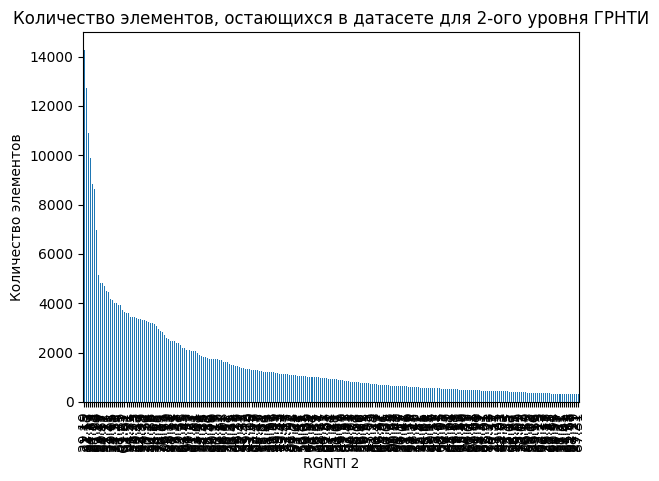

In [6]:
if not os.path.exists(path_info_before_save):
    os.makedirs(path_info_before_save)
df, df_test, n_classes, n_classes2 = get_grnti1_2_BERT_dataframes("../datasets/base/ru/raw", 
                                            number_of_delteted_values=number_of_delteted_values, 
                                minimal_number_of_elements_RGNTI2=minimal_number_of_elements_RGNTI2,
                                minimal_number_of_words=minimal_number_of_words,
                                dir_name=path_info_before_save, grnti_folder = "grnti_dicts_level2/")

In [7]:
df = prepair_data_level2(df, df["target_coded"],
                         path_to_grnti_model_codes="grnti_dicts_level2/")

Подготовка данных 2 уровень


100%|██████████| 279659/279659 [00:00<00:00, 578979.51it/s]


Доля непредсказанных классов GRNTI 1 для статей: 0.0


In [8]:
df.shape

(279659, 13)

In [9]:
with open("trainer_predictions_level1_extra.npy", 'rb') as f:#trainer_predictions_level1

    prediction1_experiment = np.load(f)

In [10]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [11]:
label_test = sigmoid_array(prediction1_experiment) >= 0.5

In [12]:
label_test.shape, df_test.shape

((166183, 36), (166183, 13))

In [13]:
df_test = prepair_data_level2(df_test, label_test, 
                              path_to_grnti_model_codes="grnti_dicts_level1/")

Подготовка данных 2 уровень


  0%|          | 0/166183 [00:00<?, ?it/s]

100%|██████████| 166183/166183 [00:07<00:00, 21040.34it/s]


Доля непредсказанных классов GRNTI 1 для статей: 0.05179831872092813


In [14]:
df_test.shape

(166183, 13)

In [15]:
df_test.head()['text']

0    Математика; Обратная задача для уравнения в ба...
1    Физика; Моделирование динамики безмассовых нос...
2    Металлургия; Градиентные дислокационные субстр...
3    Организация и управление; Особенности корпорат...
4    Биология; Оценка экстерьера коров герефордской...
Name: text, dtype: object

In [16]:
n_classes, n_classes2

(47, 246)

In [17]:
train_dataset, validation_dataset, test_dataset,\
tokenizer, collate_fn, class_weights = prepair_datasets(df, df_test,
                                                        n_classes2, 
                                                        level = '2',
                                                        max_number_tokens=max_number_tokens, 
                                                        pre_trained_model_name=pre_trained_model_name)

Веса для кажого класса:  tensor([0.3324, 0.3050, 1.0957, 1.0359, 1.6289, 0.9368, 0.6091, 1.0129, 0.8051,
        1.0997, 0.9416, 0.4420, 2.2994, 0.6026, 0.3403, 0.5159, 0.6951, 2.6470,
        0.8494, 3.0454, 1.1965, 3.6569, 3.1184, 2.4879, 0.6715, 1.6677, 2.5795,
        0.5499, 1.0763, 2.0101, 2.9092, 1.5381, 0.1151, 1.7578, 2.5722, 0.1291,
        1.8321, 0.9995, 0.1317, 1.5645, 0.3132, 2.1127, 0.9802, 0.8174, 0.3629,
        0.9263, 1.9089, 2.7181, 1.1037, 1.5076, 1.4161, 2.0012, 2.7262, 2.7262,
        0.3832, 2.3348, 2.8367, 1.1719, 1.4710, 1.9752, 1.1934, 1.2076, 0.8656,
        0.6532, 0.3139, 0.1045, 1.6202, 1.8583, 1.9752, 1.4408, 1.7784, 1.1159,
        1.1325, 3.4622, 3.5991, 3.1950, 0.2844, 0.3359, 0.3512, 2.3590, 1.6348,
        2.6703, 0.4615, 1.4976, 1.5355, 0.2724, 0.7789, 2.3590, 0.8486, 0.3538,
        1.1439, 2.5016, 0.8781, 0.7464, 0.3536, 1.3734, 2.4478, 0.2879, 0.5738,
        1.0254, 2.1836, 0.3379, 1.2612, 0.7776, 1.4927, 0.2423, 0.9226, 0.9397,
        0.5495,

Map:   0%|          | 0/223999 [00:00<?, ? examples/s]

Подготовка валидационных данных:


Map:   0%|          | 0/55660 [00:00<?, ? examples/s]

Подготовка тестовых данных:


Map:   0%|          | 0/166183 [00:00<?, ? examples/s]

In [18]:
len(train_dataset['label'][0])

246

In [19]:
len(class_weights)

246

In [20]:
model = prepair_model(n_classes=n_classes2, 
                      pre_trained_model_name=pre_trained_model_name,
                        r=r, lora_alpha=lora_alpha, 
                        lora_dropout=lora_dropout)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [21]:
model.to("cuda");

In [22]:
save_parameters(dir_name= dir_name, 
                number_of_delteted_values = number_of_delteted_values, 
                minimal_number_of_elements_RGNTI2= minimal_number_of_elements_RGNTI2,
                minimal_number_of_words = minimal_number_of_words, 
                max_number_tokens= max_number_tokens, 
                pre_trained_model_name= pre_trained_model_name,
                r=r, 
                lora_alpha= lora_alpha, lora_dropout = lora_dropout,
                epoch= epoch, 
                batch_size= batch_size,
                weight_decay= weight_decay,
                warmup_steps= warmup_steps,
                fp16=fp16, 
                optim= optim)

In [23]:
compute_metrics = prepair_compute_metrics(n_classes=n_classes2)


In [24]:
training_args = TrainingArguments(
    output_dir=dir_name,          
    num_train_epochs=epoch,
    warmup_steps=warmup_steps,
    logging_dir=dir_name,
    weight_decay=weight_decay,
    eval_strategy='epoch',
    save_strategy= "epoch",
    logging_strategy="steps",
    logging_steps = 100,
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to='tensorboard',
    overwrite_output_dir = False,
    save_safetensors = False,
    fp16=fp16,
    optim = optim,
    per_device_train_batch_size= batch_size,
    per_device_eval_batch_size= batch_size,
    group_by_length=True,#True,
    dataloader_num_workers  = 4

    )

In [25]:
train_dataset = train_dataset.remove_columns("text")
validation_dataset = validation_dataset.remove_columns(["text", "__index_level_0__"])

In [26]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    data_collator = collate_fn,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

In [27]:
train_dataset, validation_dataset

(Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 223999
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 55660
 }))

In [34]:
model.base_model.model.classifier.original_module.weight.requires_grad,\
model.base_model.model.classifier.modules_to_save["default"].weight.requires_grad,\
model.base_model.model.classifier.active_adapter

(False, True, 'default')

In [36]:
torch.allclose(
    model.base_model.model.classifier.modules_to_save["default"].weight, 
    model.base_model.model.classifier.original_module.weight
)

True

In [37]:
trainer.train()

  0%|          | 0/224000 [00:00<?, ?it/s]

c:\Users\victo\git_Work_VINITI_2024\my_venv_cuda\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.6658, 'grad_norm': 0.40869003534317017, 'learning_rate': 4.9979909817402566e-05, 'epoch': 0.0}
{'loss': 0.0857, 'grad_norm': 0.09985783696174622, 'learning_rate': 4.9957587392294306e-05, 'epoch': 0.01}
{'loss': 0.0388, 'grad_norm': 0.06746967881917953, 'learning_rate': 4.993526496718603e-05, 'epoch': 0.01}
{'loss': 0.0314, 'grad_norm': 0.06872254610061646, 'learning_rate': 4.991294254207777e-05, 'epoch': 0.01}
{'loss': 0.0297, 'grad_norm': 0.05978674441576004, 'learning_rate': 4.989062011696951e-05, 'epoch': 0.02}
{'loss': 0.0282, 'grad_norm': 0.06612329930067062, 'learning_rate': 4.986829769186125e-05, 'epoch': 0.02}
{'loss': 0.0265, 'grad_norm': 0.05450468510389328, 'learning_rate': 4.9845975266752984e-05, 'epoch': 0.03}
{'loss': 0.027, 'grad_norm': 0.06962275505065918, 'learning_rate': 4.982365284164472e-05, 'epoch': 0.03}
{'loss': 0.0278, 'grad_norm': 0.6884397864341736, 'learning_rate': 4.980133041653646e-05, 'epoch': 0.03}
{'loss': 0.0267, 'grad_norm': 0.05922694504261

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.017214439809322357, 'eval_accuracy_micro_0.5': 0.9945311546325684, 'eval_accuracy_macro_0.5': 0.9945312142372131, 'eval_accuracy_weighted_0.5': 0.9866402745246887, 'eval_f1_micro_0.5': 0.07621608674526215, 'eval_f1_macro_0.5': 0.010311615653336048, 'eval_f1_weighted_0.5': 0.04976670816540718, 'eval_f1_micro_0.6': 0.0318930558860302, 'eval_f1_macro_0.6': 0.0046495841816067696, 'eval_f1_weighted_0.6': 0.024213138967752457, 'eval_f1_micro_0.7': 0.005877282470464706, 'eval_f1_macro_0.7': 0.0009384853183291852, 'eval_f1_weighted_0.7': 0.005404936149716377, 'eval_f1_micro_0.8': 0.0004194960929453373, 'eval_f1_macro_0.8': 0.0, 'eval_f1_weighted_0.8': 0.0, 'eval_f1_micro_0.9': 0.0, 'eval_aucroc_micro': 0.583669126033783, 'eval_aucroc_macro': 0.5224112868309021, 'eval_aucroc_weighted': 0.5813645124435425, 'eval_runtime': 2091.9397, 'eval_samples_per_second': 26.607, 'eval_steps_per_second': 3.326, 'epoch': 1.0}
{'loss': 0.0185, 'grad_norm': 0.052286114543676376, 'learning_rate':

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.011272122152149677, 'eval_accuracy_micro_0.5': 0.9953721165657043, 'eval_accuracy_macro_0.5': 0.9953719973564148, 'eval_accuracy_weighted_0.5': 0.9893978834152222, 'eval_f1_micro_0.5': 0.388980507850647, 'eval_f1_macro_0.5': 0.16185614466667175, 'eval_f1_weighted_0.5': 0.2982958257198334, 'eval_f1_micro_0.6': 0.2839444875717163, 'eval_f1_macro_0.6': 0.11074259877204895, 'eval_f1_weighted_0.6': 0.20994782447814941, 'eval_f1_micro_0.7': 0.1915363371372223, 'eval_f1_macro_0.7': 0.07077891379594803, 'eval_f1_weighted_0.7': 0.1418057680130005, 'eval_f1_micro_0.8': 0.10339121520519257, 'eval_f1_macro_0.8': 0.012978658080101013, 'eval_f1_weighted_0.8': 0.021937359124422073, 'eval_f1_micro_0.9': 0.025519249960780144, 'eval_aucroc_micro': 0.7769649028778076, 'eval_aucroc_macro': 0.6755794286727905, 'eval_aucroc_weighted': 0.7743046283721924, 'eval_runtime': 2198.2879, 'eval_samples_per_second': 25.32, 'eval_steps_per_second': 3.165, 'epoch': 2.0}
{'loss': 0.0127, 'grad_norm': 0.

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.009481274522840977, 'eval_accuracy_micro_0.5': 0.9959058165550232, 'eval_accuracy_macro_0.5': 0.9959058165550232, 'eval_accuracy_weighted_0.5': 0.990726113319397, 'eval_f1_micro_0.5': 0.5038543343544006, 'eval_f1_macro_0.5': 0.2762102484703064, 'eval_f1_weighted_0.5': 0.41893014311790466, 'eval_f1_micro_0.6': 0.42129960656166077, 'eval_f1_macro_0.6': 0.21123698353767395, 'eval_f1_weighted_0.6': 0.3346352279186249, 'eval_f1_micro_0.7': 0.32352250814437866, 'eval_f1_macro_0.7': 0.15309913456439972, 'eval_f1_weighted_0.7': 0.2515681982040405, 'eval_f1_micro_0.8': 0.20129014551639557, 'eval_f1_macro_0.8': 0.03688640519976616, 'eval_f1_weighted_0.8': 0.06095576658844948, 'eval_f1_micro_0.9': 0.0774727612733841, 'eval_aucroc_micro': 0.8270954489707947, 'eval_aucroc_macro': 0.7516735792160034, 'eval_aucroc_weighted': 0.8252253532409668, 'eval_runtime': 1358.7711, 'eval_samples_per_second': 40.963, 'eval_steps_per_second': 5.121, 'epoch': 3.0}
{'loss': 0.0105, 'grad_norm': 0.04

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.008516516536474228, 'eval_accuracy_micro_0.5': 0.9964196085929871, 'eval_accuracy_macro_0.5': 0.9964197278022766, 'eval_accuracy_weighted_0.5': 0.9921014308929443, 'eval_f1_micro_0.5': 0.6096317768096924, 'eval_f1_macro_0.5': 0.4029046595096588, 'eval_f1_weighted_0.5': 0.5391151905059814, 'eval_f1_micro_0.6': 0.5436211824417114, 'eval_f1_macro_0.6': 0.3261716365814209, 'eval_f1_weighted_0.6': 0.4660380184650421, 'eval_f1_micro_0.7': 0.4475298821926117, 'eval_f1_macro_0.7': 0.2500915825366974, 'eval_f1_weighted_0.7': 0.3700760304927826, 'eval_f1_micro_0.8': 0.3219946324825287, 'eval_f1_macro_0.8': 0.08836128562688828, 'eval_f1_weighted_0.8': 0.12676939368247986, 'eval_f1_micro_0.9': 0.16015952825546265, 'eval_aucroc_micro': 0.8705670833587646, 'eval_aucroc_macro': 0.8118174076080322, 'eval_aucroc_weighted': 0.8689566254615784, 'eval_runtime': 1364.1416, 'eval_samples_per_second': 40.802, 'eval_steps_per_second': 5.101, 'epoch': 4.0}
{'loss': 0.0104, 'grad_norm': 0.067231

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.007899136282503605, 'eval_accuracy_micro_0.5': 0.9966867566108704, 'eval_accuracy_macro_0.5': 0.9966867566108704, 'eval_accuracy_weighted_0.5': 0.9927047491073608, 'eval_f1_micro_0.5': 0.6498023867607117, 'eval_f1_macro_0.5': 0.47257909178733826, 'eval_f1_weighted_0.5': 0.5938537120819092, 'eval_f1_micro_0.6': 0.589738130569458, 'eval_f1_macro_0.6': 0.38797107338905334, 'eval_f1_weighted_0.6': 0.521509051322937, 'eval_f1_micro_0.7': 0.4981320798397064, 'eval_f1_macro_0.7': 0.30113059282302856, 'eval_f1_weighted_0.7': 0.4241359531879425, 'eval_f1_micro_0.8': 0.3758956491947174, 'eval_f1_macro_0.8': 0.11627963185310364, 'eval_f1_weighted_0.8': 0.16494615375995636, 'eval_f1_micro_0.9': 0.2076910436153412, 'eval_aucroc_micro': 0.8892092704772949, 'eval_aucroc_macro': 0.8385359644889832, 'eval_aucroc_weighted': 0.8877576589584351, 'eval_runtime': 1343.1542, 'eval_samples_per_second': 41.44, 'eval_steps_per_second': 5.18, 'epoch': 5.0}
{'loss': 0.0093, 'grad_norm': 0.03536677

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.007512271869927645, 'eval_accuracy_micro_0.5': 0.9968944787979126, 'eval_accuracy_macro_0.5': 0.9968944191932678, 'eval_accuracy_weighted_0.5': 0.9931644201278687, 'eval_f1_micro_0.5': 0.6819025278091431, 'eval_f1_macro_0.5': 0.5309708118438721, 'eval_f1_weighted_0.5': 0.6350528001785278, 'eval_f1_micro_0.6': 0.6301236748695374, 'eval_f1_macro_0.6': 0.45073202252388, 'eval_f1_weighted_0.6': 0.5716562271118164, 'eval_f1_micro_0.7': 0.5460224151611328, 'eval_f1_macro_0.7': 0.35498470067977905, 'eval_f1_weighted_0.7': 0.47805386781692505, 'eval_f1_micro_0.8': 0.4215230345726013, 'eval_f1_macro_0.8': 0.14475567638874054, 'eval_f1_weighted_0.8': 0.1972665935754776, 'eval_f1_micro_0.9': 0.24827350676059723, 'eval_aucroc_micro': 0.9024308323860168, 'eval_aucroc_macro': 0.8611253499984741, 'eval_aucroc_weighted': 0.901071310043335, 'eval_runtime': 1386.0527, 'eval_samples_per_second': 40.157, 'eval_steps_per_second': 5.02, 'epoch': 6.0}
{'loss': 0.0092, 'grad_norm': 0.045793086

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.0072485520504415035, 'eval_accuracy_micro_0.5': 0.9969418048858643, 'eval_accuracy_macro_0.5': 0.996941864490509, 'eval_accuracy_weighted_0.5': 0.9932885766029358, 'eval_f1_micro_0.5': 0.6873721480369568, 'eval_f1_macro_0.5': 0.5350632071495056, 'eval_f1_weighted_0.5': 0.6410492658615112, 'eval_f1_micro_0.6': 0.6393948793411255, 'eval_f1_macro_0.6': 0.4560379087924957, 'eval_f1_weighted_0.6': 0.580713152885437, 'eval_f1_micro_0.7': 0.560388445854187, 'eval_f1_macro_0.7': 0.36609023809432983, 'eval_f1_weighted_0.7': 0.4944854974746704, 'eval_f1_micro_0.8': 0.4358796775341034, 'eval_f1_macro_0.8': 0.1547846496105194, 'eval_f1_weighted_0.8': 0.20792299509048462, 'eval_f1_micro_0.9': 0.2596377432346344, 'eval_aucroc_micro': 0.9026721119880676, 'eval_aucroc_macro': 0.8596566319465637, 'eval_aucroc_weighted': 0.9013595581054688, 'eval_runtime': 1367.6838, 'eval_samples_per_second': 40.697, 'eval_steps_per_second': 5.087, 'epoch': 7.0}
{'loss': 0.0084, 'grad_norm': 0.054954554

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.007173060905188322, 'eval_accuracy_micro_0.5': 0.9969756007194519, 'eval_accuracy_macro_0.5': 0.9969756603240967, 'eval_accuracy_weighted_0.5': 0.9933416843414307, 'eval_f1_micro_0.5': 0.6918893456459045, 'eval_f1_macro_0.5': 0.5453409552574158, 'eval_f1_weighted_0.5': 0.6472892165184021, 'eval_f1_micro_0.6': 0.645763099193573, 'eval_f1_macro_0.6': 0.4685608446598053, 'eval_f1_weighted_0.6': 0.5884718298912048, 'eval_f1_micro_0.7': 0.5681741237640381, 'eval_f1_macro_0.7': 0.37845391035079956, 'eval_f1_weighted_0.7': 0.5022222995758057, 'eval_f1_micro_0.8': 0.4454200863838196, 'eval_f1_macro_0.8': 0.15995651483535767, 'eval_f1_weighted_0.8': 0.21403546631336212, 'eval_f1_micro_0.9': 0.26624637842178345, 'eval_aucroc_micro': 0.9042285084724426, 'eval_aucroc_macro': 0.8632780909538269, 'eval_aucroc_weighted': 0.9029529094696045, 'eval_runtime': 1225.3229, 'eval_samples_per_second': 45.425, 'eval_steps_per_second': 5.679, 'epoch': 8.0}
{'train_runtime': 72037.7673, 'train_s

TrainOutput(global_step=224000, training_loss=0.012346282782831362, metrics={'train_runtime': 72037.7673, 'train_samples_per_second': 24.876, 'train_steps_per_second': 3.109, 'total_flos': 2.0491807243665766e+17, 'train_loss': 0.012346282782831362, 'epoch': 8.0})

In [38]:
trainer.model.save_pretrained("bert_peft_level2_with_labels_extra")

In [30]:
# trainer.save_model("bert_peft_level2_with_labels_v2")

### Test level 2 with labels 

In [39]:
test_dataset = test_dataset.remove_columns(["text", "__index_level_0__"])

In [40]:
# model = prepair_model_test(246, lora_model_path="bert_peft_level2_with_labels_v2")

In [41]:
test_dataset

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 166183
})

In [142]:
from torch.utils.data import DataLoader


In [143]:
from transformers import DataCollatorWithPadding

In [144]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)


In [145]:
test_dataset

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 166183
})

In [146]:
test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn,
                             shuffle=False)


In [147]:
for el in test_dataloader:
    first_el = el
    break


In [148]:
torch.equal(first_el['labels'][0], test_dataset[0]['label'])

True

In [149]:
# for el in test_dataset:
#     print(len(el['label']))
#     break

In [150]:
model.device

device(type='cpu')

In [151]:
model.to('cuda');

In [152]:
import tqdm

In [153]:
model.eval()
# y_pred_list = []
y_pred_list_no_threshold = []
# count = 0
# tic = time.process_time()

for i, batch in enumerate(test_dataloader):
    # if count == 3:
    #     break

    inputs = batch['input_ids'].to(device = 'cuda', dtype=torch.long)
    mask = batch['attention_mask'].to(device = 'cuda', dtype=torch.long)# может не надо
    token_type_ids = batch['token_type_ids'].to(device = 'cuda', dtype=torch.long)


    with torch.no_grad():
        output = model(input_ids = inputs, attention_mask = mask, 
                        token_type_ids = token_type_ids)
    
    # Move logits and labels to CPU
    logits = output.logits.detach().cpu()
    y_pred_no_threshold = logits.numpy()
    y_pred_list_no_threshold.append(y_pred_no_threshold)
    break




In [154]:
sigmoid_array(y_pred_list_no_threshold[0])

array([[0.4575, 0.4062, 0.5063, ..., 0.585 , 0.505 , 0.5483],
       [0.428 , 0.4006, 0.4985, ..., 0.6025, 0.4863, 0.525 ],
       [0.4375, 0.3901, 0.515 , ..., 0.605 , 0.4802, 0.508 ],
       ...,
       [0.4736, 0.431 , 0.528 , ..., 0.5522, 0.531 , 0.513 ],
       [0.4514, 0.4172, 0.5093, ..., 0.588 , 0.5103, 0.522 ],
       [0.4246, 0.3872, 0.5034, ..., 0.6206, 0.444 , 0.5083]],
      dtype=float16)

In [130]:
from transformers import AutoModelForSequenceClassification


In [131]:

lora_model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased',
                                                            problem_type="multi_label_classification",
                                                            num_labels=246)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [132]:
from peft import get_peft_model,  PeftModel

lora_model =  PeftModel.from_pretrained(lora_model, "bert_peft_level2_with_labels_v2")

In [133]:
lora_model.to('cuda');

In [134]:
lora_model.eval()
for i, batch in enumerate(test_dataloader):
    # if count == 3:
    #     break

    inputs = batch['input_ids'].to(device = 'cuda', dtype=torch.long)
    mask = batch['attention_mask'].to(device = 'cuda', dtype=torch.long)# может не надо
    token_type_ids = batch['token_type_ids'].to(device = 'cuda', dtype=torch.long)


    with torch.no_grad():
        output = lora_model(input_ids = inputs, attention_mask = mask, 
                        token_type_ids = token_type_ids)
    
    # Move logits and labels to CPU
    logits = output.logits.detach().cpu()
    y_pred_no_threshold = logits.numpy()
    y_pred_list_no_threshold.append(y_pred_no_threshold)
    break

In [137]:
sigmoid_array(y_pred_list_no_threshold[0]), sigmoid_array(y_pred_list_no_threshold[1])

(array([[0.483 , 0.508 , 0.4622, ..., 0.488 , 0.565 , 0.5273],
        [0.4692, 0.513 , 0.4568, ..., 0.496 , 0.5635, 0.531 ],
        [0.4768, 0.5107, 0.457 , ..., 0.505 , 0.5493, 0.533 ],
        ...,
        [0.4812, 0.4854, 0.496 , ..., 0.5063, 0.5493, 0.512 ],
        [0.4802, 0.4915, 0.4707, ..., 0.509 , 0.5454, 0.526 ],
        [0.4875, 0.4866, 0.4302, ..., 0.506 , 0.539 , 0.544 ]],
       dtype=float16),
 array([[1.16446253e-03, 3.26357374e-04, 7.30434112e-05, ...,
         5.49428987e-05, 2.06039986e-04, 4.78147389e-03],
        [4.72547039e-02, 1.45343556e-05, 5.24893994e-06, ...,
         1.42714907e-06, 1.65306039e-06, 6.82232022e-01],
        [8.67804396e-04, 3.72567411e-05, 9.16071349e-06, ...,
         1.63802497e-06, 3.24911093e-06, 1.48760468e-01],
        ...,
        [2.62606132e-04, 1.38132338e-04, 9.49919649e-06, ...,
         9.87066528e-07, 5.31586375e-06, 2.16608882e-04],
        [6.83571794e-04, 5.46562136e-04, 8.23623559e-05, ...,
         8.83496949e-04, 2.894

In [97]:
predict_res = make_predictions(model, test_dataloader, 'cuda', threshold=None)

Предсказние модели


  0%|          | 54/20773 [00:02<14:46, 23.36it/s] 


KeyboardInterrupt: 

In [40]:
# with open("trainer_predictions_level2_with_labels_extra.npy", 'wb') as f:
#     np.save(f, predict_res)

In [51]:
# with open("trainer_predictions_level2_with_labels_extra.npy", 'rb') as f:#trainer_predictions_level2_with_labels_extra

#     prediction1_experiment = np.load(f)

In [42]:
predict_res = trainer.predict(test_dataset=test_dataset).predictions


  0%|          | 0/20773 [00:00<?, ?it/s]

In [53]:
# torch.save("trainer_predictions_level2_with_labels_extra.pt")#trainer_predictions_level2_with_labels

In [43]:
with open("trainer_predictions_level2_with_labels_extra.npy", 'wb') as f:
    np.save(f, predict_res)

In [44]:
with open("trainer_predictions_level2_with_labels.npy", 'rb') as f:

    prediction1_experiment = np.load(f)

In [45]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [46]:
label_test = np.vstack(df_test["target_coded2"])

In [47]:
test_predictons(sigmoid_array(prediction1_experiment), label_test, path_info_before_save, 246, 
                   level=2, grnti_path="grnti_dicts_level2/")

100%|██████████| 18/18 [06:41<00:00, 22.32s/it]


Cтатистика количества пркдсказываемых классов при заданном threshold:
Среднее число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1.6306)
Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1)
Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(9)
Доля статей c пустым ответом классификатора (Empty): 0.12718509113447218
recall_micro_list threshold: [tensor(0.6976), tensor(0.6567), tensor(0.6218), tensor(0.5900), tensor(0.5606), tensor(0.5322), tensor(0.5045), tensor(0.4765), tensor(0.4478), tensor(0.4180), tensor(0.3848), tensor(0.3479), tensor(0.3069), tensor(0.2618), tensor(0.2131), tensor(0.1625), tensor(0.1118), tensor(0.0508)]
recall_macro_list threshold: [tensor(0.6165), tensor(0.5679), tensor(0.5268), tensor(0.4886), tensor(0.4538), tensor(0.4227), tensor(0.3927), tensor(0.3628), tensor(0.3331), tensor(0.3039), tensor(0.2728), tensor(0.2411), ten

100%|██████████| 18/18 [00:03<00:00,  4.85it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 3/3 [01:16<00:00, 25.66s/it]


Количество отказов от классификации (Reject) tensor(0)
Доля отказов от классификации (Reject) tensor(0.)
f1_top_k_macro [0.35 0.39 0.36]
f1_top_k_maicro [0.5  0.48 0.42]
f1_top_k_weighted [0.45 0.47 0.43]
precision_top_k_macro [0.52 0.38 0.29]
precision_top_k_maicro [0.57 0.4  0.3 ]
precision_top_k_weighted [0.56 0.42 0.33]
recall_top_k_macro: tensor([0.3321, 0.4966, 0.5844])
recall_top_k_micro: tensor([0.4391, 0.6101, 0.6887])
recall_top_k_weighted: tensor([0.4391, 0.6101, 0.6887])


<Figure size 640x480 with 0 Axes>

### Изучение тектсов

In [7]:
df['text']

0         Некоторые аспекты изменения степных ландшафтов...
1         Подходы к повышению точности определения харак...
2         Микроскопическое моделирование фазового поля п...
3         МОДЕЛИ И МЕТОДИКИ АВТОМАТИЗАЦИИ ПРОЦЕДУР РАЗРА...
4         Трехкомпонентная реакция Кастагноли-Кушмана 3-...
                                ...                        
293502    Разработка состава эмульгеля для вагинального ...
293503    Неконвекционная теория скейлинга в квантовом ф...
293504    Влияние финансовой грамотности населения на ра...
293505    Резистентное расстояние в прямолинейных 2-дере...
293506    Активная и пассивная политика на российском ры...
Name: text, Length: 290794, dtype: object

In [12]:
import re

In [41]:
# Регулярные выражения для удаления формул
def remove_latex_formulas_stat(text, dictionary):
    # Удалить формулы внутри $$...$$
    text1 = re.sub(r'\$\$.*?\$\$', '', text, flags=re.DOTALL)
    # Удалить формулы внутри $...$
    text2 = re.sub(r'\$.*?\$', '', text, flags=re.DOTALL)
    # Удалить формулы внутри \[...\] или \(...\)
    text3 = re.sub(r'\\\[.*?\\\]', '', text, flags=re.DOTALL)
    # Удалить окружения формул (\begin{...}...\end{...})
    text4 = re.sub(r'\\begin\{.*?\}.*?\\end\{.*?\}', '', text, flags=re.DOTALL)
    # Ссылки
    text5 = re.sub('https?://\S+|www\.\S+', '', text)
    # Удаляем элементы в скобках <>
    text6 = re.sub('<.*?>+', '', text)
    # Перенос строки
    text7 = re.sub('\n', '', text)
    # Число посреди слова
    text8 = re.sub('\w*\d\w*', '', text)

    for i, texti in enumerate([text1, text2, text3, text4, text5, text6, text7, text8]):
        if text is not texti:

            dictionary[str(i+1)] = dictionary[str(i+1)] + 1

In [42]:
dictionary = {'1':0,
              '2':0,
              '3':0,
              '4':0,
              '5':0,
              '6':0,
              '7':0,
              '8':0}
for text in df['text']:
    remove_latex_formulas_stat(text, dictionary)

In [43]:
dictionary

{'1': 282, '2': 2941, '3': 0, '4': 0, '5': 243, '6': 1219, '7': 0, '8': 181091}

In [44]:
def remove_latex_formulas_stat(text):
    # Удалить формулы внутри $$...$$
    text = re.sub(r'\$\$.*?\$\$', '', text, flags=re.DOTALL)
    # Удалить формулы внутри $...$
    text = re.sub(r'\$.*?\$', '', text, flags=re.DOTALL)
    # Удалить формулы внутри \[...\] или \(...\)
    text = re.sub(r'\\\[.*?\\\]', '', text, flags=re.DOTALL)
    # Удалить окружения формул (\begin{...}...\end{...})
    text = re.sub(r'\\begin\{.*?\}.*?\\end\{.*?\}', '', text, flags=re.DOTALL)
    # Ссылки
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Удаляем элементы в скобках <>
    text = re.sub('<.*?>+', '', text)
    # Перенос строки
    text = re.sub('\n', '', text)
    # Число посреди слова
    text = re.sub('\w*\d\w*', '', text)
    return text

In [45]:
new_text = df['text'].progress_apply(remove_latex_formulas_stat)

  0%|          | 0/290794 [00:00<?, ?it/s]